In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# You can install lightgbm module with !pip install LIGHTGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import zscore

sns.set_context(rc={"font.size":20,"axes.titlesize":20, "xtick.labelsize":20, "ytick.labelsize":20, "axes.labelsize":20})

In [2]:
df = pd.read_csv('diamonds.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [4]:
df.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


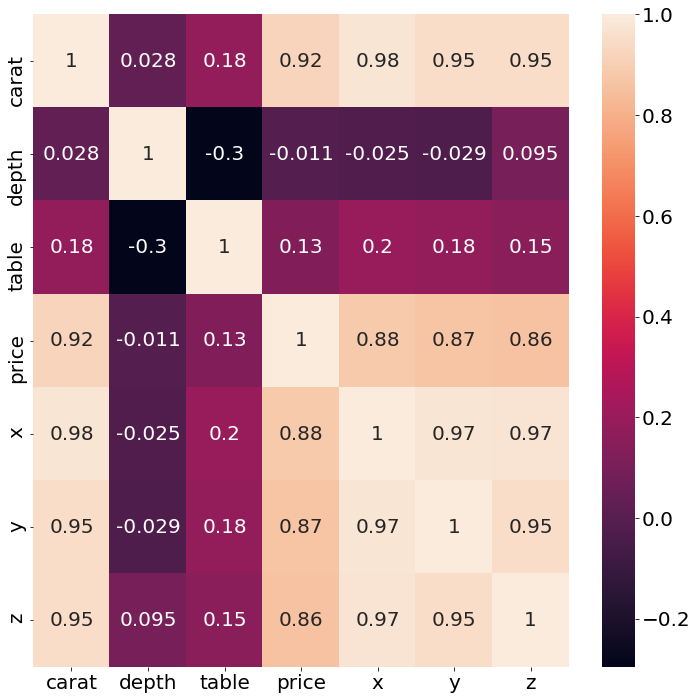

In [5]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)

Very strong correlation between (carat, x, y, z) and price.

Almost no correlation between (table, depth) and price.

In [6]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

We have no null values in our data. 

In [7]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Our data seems to have some extreme values in x, y and z. These are the dimensions of the diamond so a dimensionless diamond is not possible. The standard deviation of the price column is also very high very high.

In [8]:
print(len(df[df['x']==0]))
print(len(df[df['y']==0]))
print(len(df[df['z']==0]))

8
7
20


In [9]:
# Dropping all rows where dimensions are 0.
# As there are only 20 rows to be dropped, it shouldn't affect our dataset much.

df = df.drop(df[df['x']==0].index)
df = df.drop(df[df['y']==0].index)
df = df.drop(df[df['z']==0].index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D6FB51E2C8>,
      dtype=object)

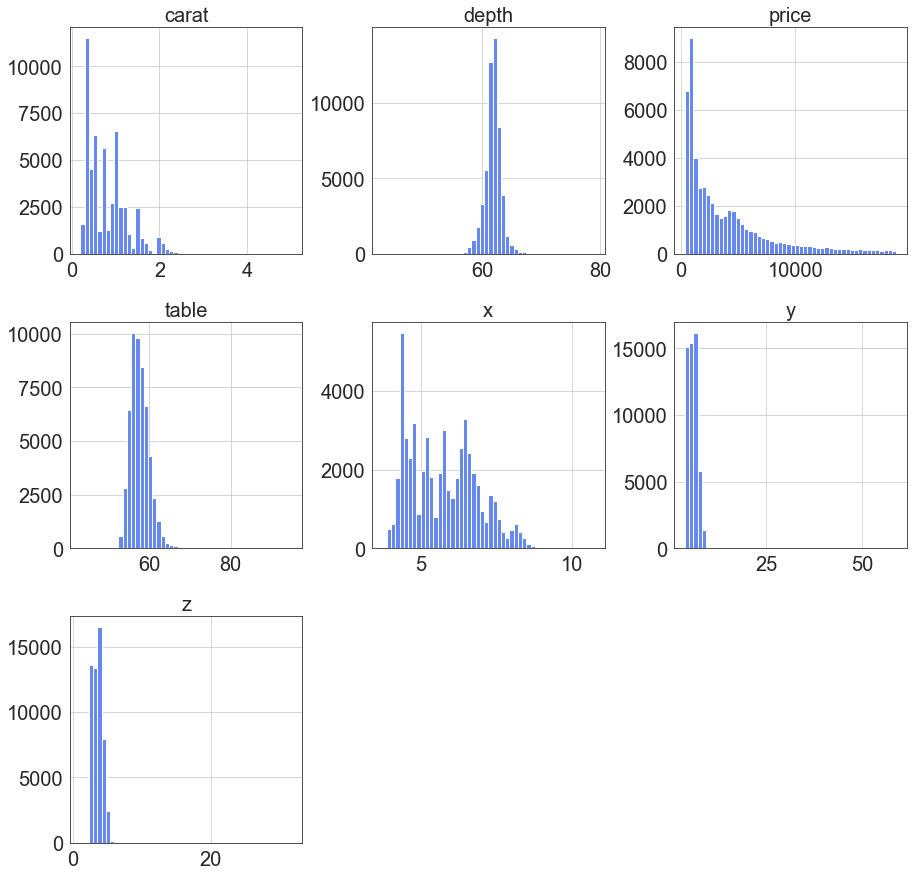

In [10]:
sns.set_style('white')
sns.set_palette('coolwarm')
df.hist(figsize= (15, 15), bins = 50)

<Figure size 1440x1440 with 0 Axes>

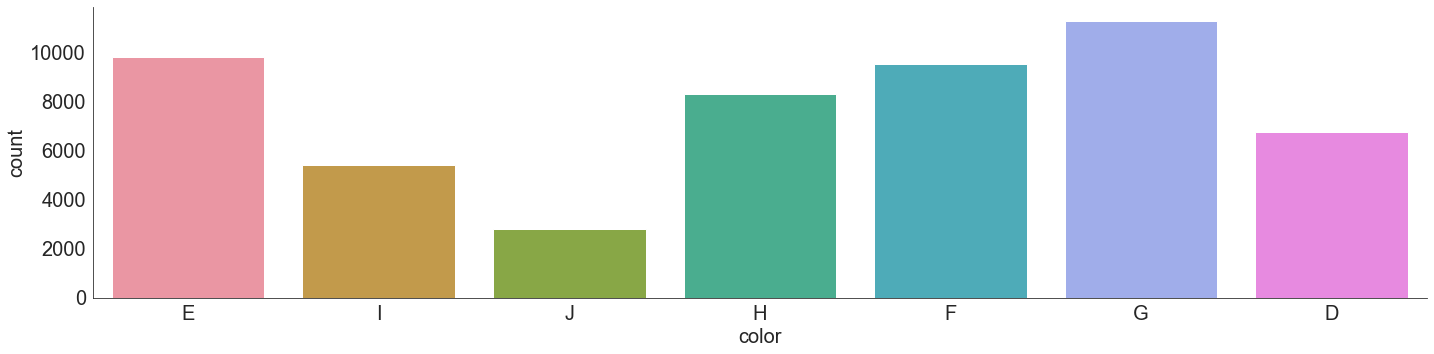

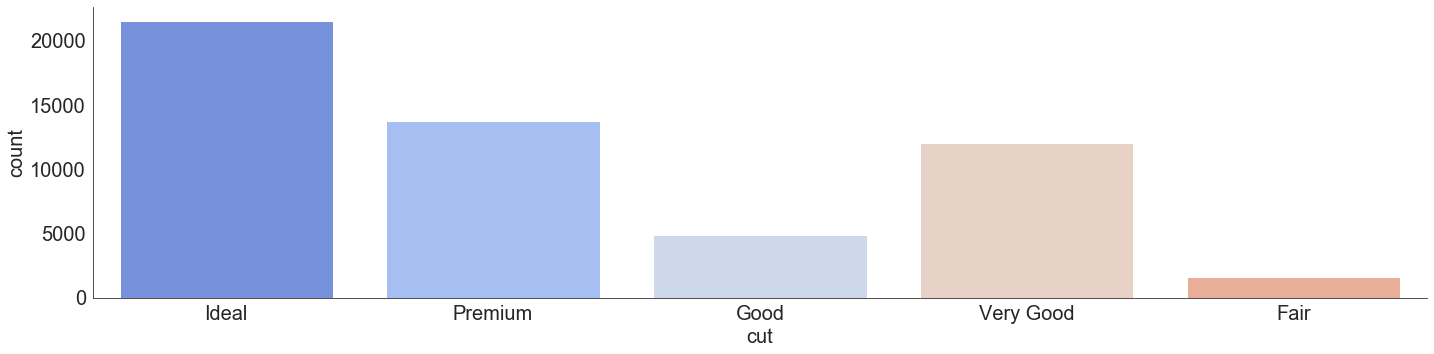

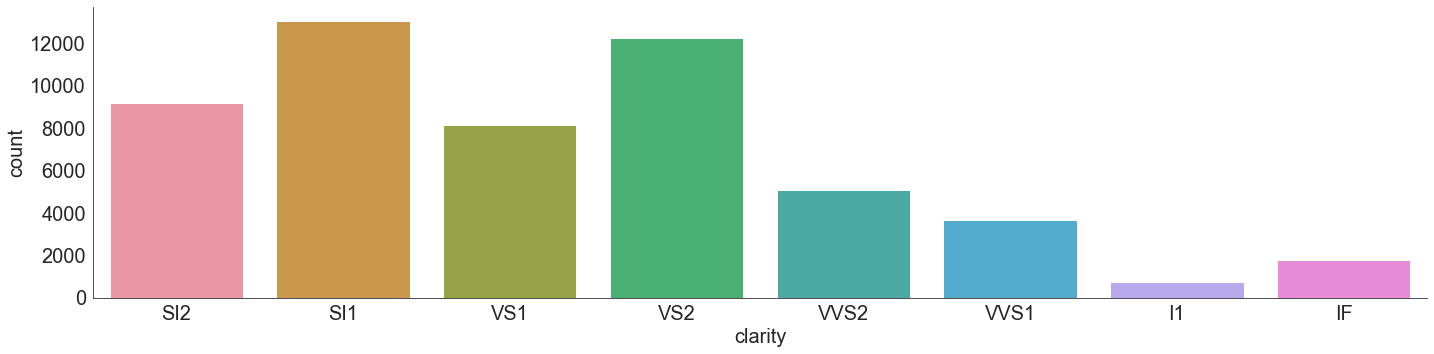

In [11]:
plt.figure(figsize = (20,20))
 
sns.catplot(x= 'color', kind='count', data=df, aspect = 20/5)
sns.catplot(x= 'cut', kind='count', data=df, aspect = 20/5)
sns.catplot(x= 'clarity', kind='count', data=df, aspect = 20/5)


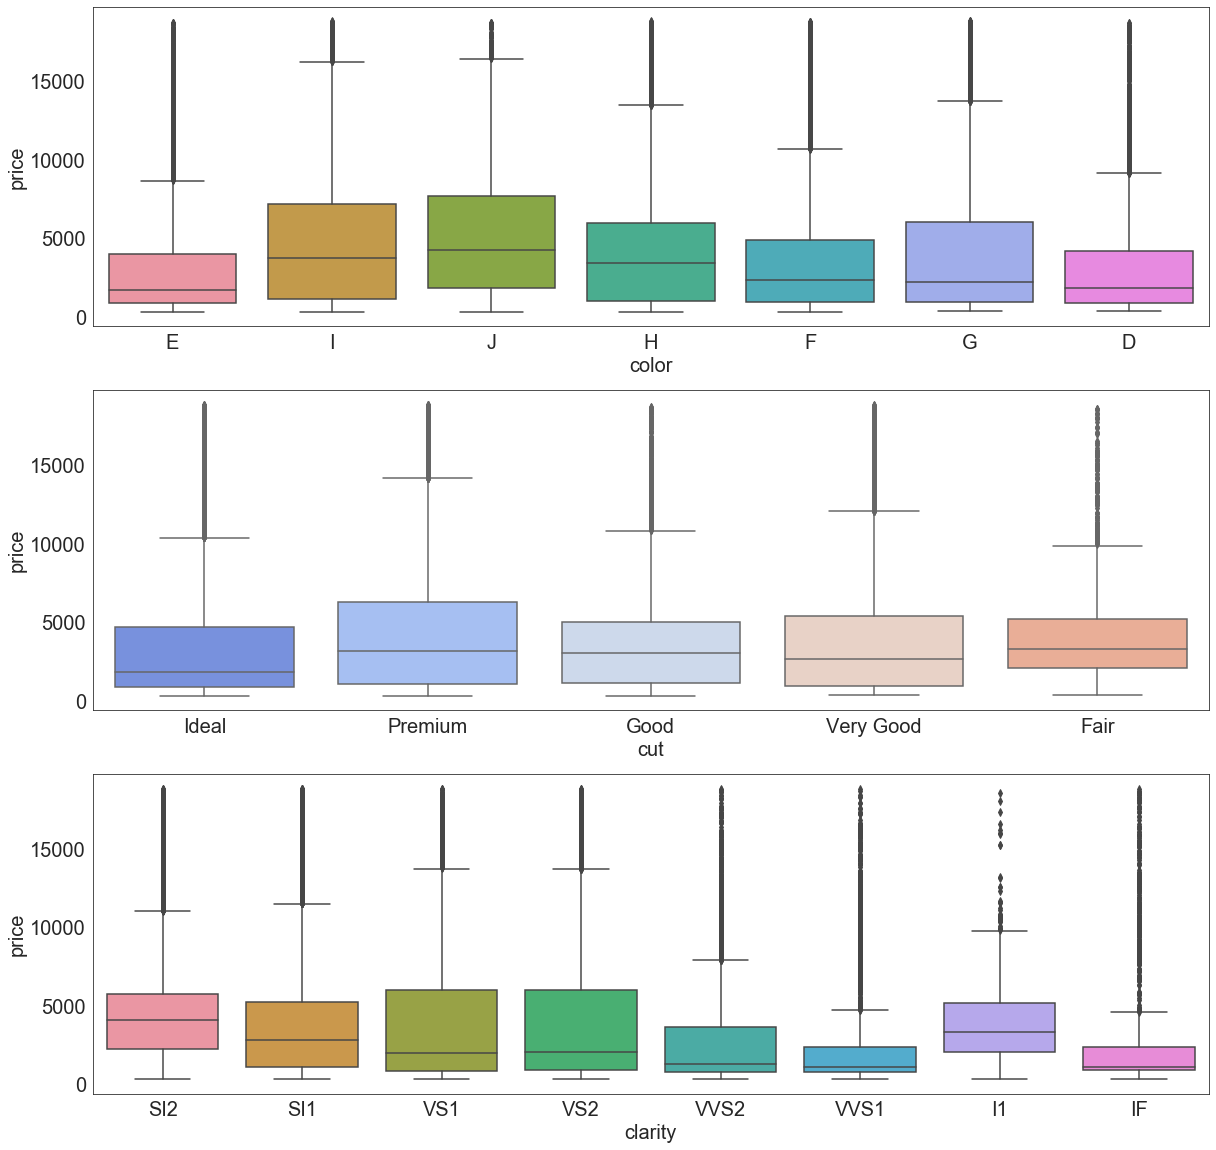

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(20, 20))
 
sns.boxplot(ax=axes[0], data=df, x= 'color', y= 'price')
sns.boxplot(ax=axes[1], data=df, x= 'cut',  y= 'price')
sns.boxplot(ax=axes[2], data=df, x= 'clarity',  y= 'price')


In [13]:
# One hot encoding categorical features
cat_features = df[['color', 'cut', 'clarity']]
df = df.drop(cat_features, axis=1)
cat_features = pd.get_dummies(cat_features)
df = pd.concat([df, cat_features], axis=1)


In [14]:
# Removing outliers in price, rows with a z score above 3
before_rows = df.shape[0]
z = np.abs(zscore(df['price']))
df = df.iloc[np.where(z<3)[0]]
after_rows = df.shape[0]
print(f'{before_rows - after_rows} rows with outliers has been removed.')

1206 rows with outliers has been removed.


In [15]:
X = df.drop('price', axis=1)
y = df['price']

In [16]:
# Checking for any collinear features which we might drop if deemed unnecessary
correlations = X.corr()

# Takes upper triangle of correlation values
# Code snippet below taken from https://stackoverflow.com/a/59878203
upper_tri = correlations.where(np.triu(np.ones(correlations.shape), k = 1).astype(np.bool))

# Selecting columns with over 95% correlation
to_be_dropped = []
for i in upper_tri.columns:
    if any(upper_tri[i].abs() > 0.95):
        to_be_dropped.append(i)
        
to_be_dropped

['x', 'y', 'z']

In [17]:
upper_tri[['x','y','z']]

,x,y,z
carat,0.979558,0.953124,0.961138
depth,-0.018720,-0.023001,0.104964
table,0.194965,0.182550,0.149906
x,NaN,0.972153,0.973118
y,NaN,NaN,0.952409
z,NaN,NaN,NaN
color_D,NaN,NaN,NaN
color_E,NaN,NaN,NaN
color_F,NaN,NaN,NaN
color_G,NaN,NaN,NaN


As expected x, y and z have a very high correlation with carat. Carat is an overall dimensions indicator for diamonds and x, y and z are also indicators for the dimensions. We can drop the 3 columns as they are unnecessary for our modelling.

In [18]:
X.drop(['x', 'y', 'z'], axis=1, inplace=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [20]:
# Training our model with 5 folds using cross validation
folds = 5
kf = KFold(n_splits = folds, random_state=789)
oof_pred = np.zeros(len(X_train))
y_pred = np.zeros(len(X_test))

# Model parameters
params = {'objective':'regression',
         'metric':'rmse',
         'max_depth':6,
         'learning_rate':0.01,
         'verbose':-1}
fold = 1
learning_curve_ = pd.DataFrame()

for train_idx, valid_idx in kf.split(X_train,y_train):
    evals = {}
    train_lgb = lgb.Dataset(X_train.iloc[train_idx], y_train.iloc[train_idx])
    valid_lgb = lgb.Dataset(X_train.iloc[valid_idx], y_train.iloc[valid_idx])
    model = lgb.train(params, train_lgb, num_boost_round=10000, valid_sets=[train_lgb, valid_lgb],
                     early_stopping_rounds=100, evals_result=evals)
    
    # Out of folds prediction array
    oof_pred[valid_idx] = model.predict(X_train.iloc[valid_idx], num_iteration=model.best_iteration)
    
    # Main prediction array
    y_pred += model.predict(X_test, num_iteration=model.best_iteration) / folds
    
    # Adding in model performance in each fold to the learning_curve dataframe
    learning_curve = pd.DataFrame()
    learning_curve['train_rmse'] = evals['training'][params['metric']]
    learning_curve['validation_rmse'] = evals['valid_1'][params['metric']]
    learning_curve['fold'] = fold
    learning_curve['Iterations'] = range(1, len(learning_curve)+1)
    
    # Concatenating for each fold with the main learning_curve_ dataframe outside the loop
    learning_curve_ = pd.concat([learning_curve_, learning_curve], axis=0)
    
    fold+=1

[1]	training's rmse: 3461.89	valid_1's rmse: 3400.57

C:\Users\CEM\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 3429.88	valid_1's rmse: 3368.75
[3]	training's rmse: 3398.21	valid_1's rmse: 3337.26
[4]	training's rmse: 3366.89	valid_1's rmse: 3306.11
[5]	training's rmse: 3335.9	valid_1's rmse: 3275.3
[6]	training's rmse: 3305.24	valid_1's rmse: 3244.81
[7]	training's rmse: 3274.91	valid_1's rmse: 3214.67
[8]	training's rmse: 3244.89	valid_1's rmse: 3184.81
[9]	training's rmse: 3215.22	valid_1's rmse: 3155.32
[10]	training's rmse: 3185.85	valid_1's rmse: 3126.11
[11]	training's rmse: 3156.83	valid_1's rmse: 3097.29
[12]	training's rmse: 3128.09	valid_1's rmse: 3068.71
[13]	training's rmse: 3099.66	valid_1's rmse: 3040.47
[14]	training's rmse: 3071.57	valid_1's rmse: 3012.56
[15]	training's rmse: 3043.74	valid_1's rmse: 2984.87
[16]	training's rmse: 3016.26	valid_1's rmse: 2957.57
[17]	training's rmse: 2989.02	valid_1's rmse: 2930.54
[18]	training's rmse: 2962.11	valid_1's rmse: 2903.79
[19]	training's rmse: 2935.46

[159]	training's rmse: 1034.03	valid_1's rmse: 999.263
[160]	training's rmse: 1028.17	valid_1's rmse: 993.677
[161]	training's rmse: 1022.71	valid_1's rmse: 988.254
[162]	training's rmse: 1017.27	valid_1's rmse: 983.038
[163]	training's rmse: 1011.74	valid_1's rmse: 977.804
[164]	training's rmse: 1006.37	valid_1's rmse: 972.645
[165]	training's rmse: 1000.83	valid_1's rmse: 967.412
[166]	training's rmse: 995.587	valid_1's rmse: 962.371
[167]	training's rmse: 990.416	valid_1's rmse: 957.45
[168]	training's rmse: 985.384	valid_1's rmse: 952.54
[169]	training's rmse: 980.258	valid_1's rmse: 947.686
[170]	training's rmse: 975.301	valid_1's rmse: 942.824
[171]	training's rmse: 970.36	valid_1's rmse: 938.127
[172]	training's rmse: 965.292	valid_1's rmse: 933.295
[173]	training's rmse: 960.402	valid_1's rmse: 928.658
[174]	training's rmse: 955.519	valid_1's rmse: 923.944
[175]	training's rmse: 950.658	valid_1's rmse: 919.315
[176]	training's rmse: 945.951	valid_1's rmse: 914.686
[177]	trainin

[333]	training's rmse: 594.302	valid_1's rmse: 591.371
[334]	training's rmse: 593.416	valid_1's rmse: 590.644
[335]	training's rmse: 592.547	valid_1's rmse: 589.867
[336]	training's rmse: 591.526	valid_1's rmse: 589.006
[337]	training's rmse: 590.701	valid_1's rmse: 588.293
[338]	training's rmse: 589.834	valid_1's rmse: 587.491
[339]	training's rmse: 588.977	valid_1's rmse: 586.761
[340]	training's rmse: 588.198	valid_1's rmse: 586.028
[341]	training's rmse: 587.381	valid_1's rmse: 585.312
[342]	training's rmse: 586.621	valid_1's rmse: 584.647
[343]	training's rmse: 585.8	valid_1's rmse: 583.92
[344]	training's rmse: 585.029	valid_1's rmse: 583.287
[345]	training's rmse: 584.265	valid_1's rmse: 582.66
[346]	training's rmse: 583.38	valid_1's rmse: 581.881
[347]	training's rmse: 582.492	valid_1's rmse: 581.118
[348]	training's rmse: 581.648	valid_1's rmse: 580.387
[349]	training's rmse: 580.843	valid_1's rmse: 579.63
[350]	training's rmse: 580.131	valid_1's rmse: 578.991
[351]	training's

[514]	training's rmse: 500.842	valid_1's rmse: 514.002
[515]	training's rmse: 500.608	valid_1's rmse: 513.853
[516]	training's rmse: 500.397	valid_1's rmse: 513.658
[517]	training's rmse: 500.019	valid_1's rmse: 513.397
[518]	training's rmse: 499.784	valid_1's rmse: 513.201
[519]	training's rmse: 499.512	valid_1's rmse: 513.004
[520]	training's rmse: 499.141	valid_1's rmse: 512.748
[521]	training's rmse: 498.927	valid_1's rmse: 512.548
[522]	training's rmse: 498.575	valid_1's rmse: 512.296
[523]	training's rmse: 498.35	valid_1's rmse: 512.158
[524]	training's rmse: 498.002	valid_1's rmse: 511.926
[525]	training's rmse: 497.794	valid_1's rmse: 511.745
[526]	training's rmse: 497.504	valid_1's rmse: 511.492
[527]	training's rmse: 497.164	valid_1's rmse: 511.277
[528]	training's rmse: 496.948	valid_1's rmse: 511.134
[529]	training's rmse: 496.74	valid_1's rmse: 510.965
[530]	training's rmse: 496.408	valid_1's rmse: 510.722
[531]	training's rmse: 496.084	valid_1's rmse: 510.496
[532]	traini

[679]	training's rmse: 467.87	valid_1's rmse: 488.909
[680]	training's rmse: 467.724	valid_1's rmse: 488.802
[681]	training's rmse: 467.596	valid_1's rmse: 488.687
[682]	training's rmse: 467.416	valid_1's rmse: 488.558
[683]	training's rmse: 467.275	valid_1's rmse: 488.462
[684]	training's rmse: 467.139	valid_1's rmse: 488.357
[685]	training's rmse: 467.024	valid_1's rmse: 488.271
[686]	training's rmse: 466.847	valid_1's rmse: 488.148
[687]	training's rmse: 466.721	valid_1's rmse: 488.045
[688]	training's rmse: 466.599	valid_1's rmse: 487.979
[689]	training's rmse: 466.487	valid_1's rmse: 487.894
[690]	training's rmse: 466.38	valid_1's rmse: 487.821
[691]	training's rmse: 466.267	valid_1's rmse: 487.738
[692]	training's rmse: 466.098	valid_1's rmse: 487.632
[693]	training's rmse: 465.973	valid_1's rmse: 487.531
[694]	training's rmse: 465.875	valid_1's rmse: 487.455
[695]	training's rmse: 465.762	valid_1's rmse: 487.402
[696]	training's rmse: 465.649	valid_1's rmse: 487.321
[697]	traini

[846]	training's rmse: 450.433	valid_1's rmse: 477.611
[847]	training's rmse: 450.342	valid_1's rmse: 477.547
[848]	training's rmse: 450.273	valid_1's rmse: 477.516
[849]	training's rmse: 450.177	valid_1's rmse: 477.458
[850]	training's rmse: 450.088	valid_1's rmse: 477.401
[851]	training's rmse: 450.017	valid_1's rmse: 477.358
[852]	training's rmse: 449.954	valid_1's rmse: 477.305
[853]	training's rmse: 449.885	valid_1's rmse: 477.28
[854]	training's rmse: 449.822	valid_1's rmse: 477.241
[855]	training's rmse: 449.754	valid_1's rmse: 477.207
[856]	training's rmse: 449.671	valid_1's rmse: 477.15
[857]	training's rmse: 449.613	valid_1's rmse: 477.114
[858]	training's rmse: 449.531	valid_1's rmse: 477.052
[859]	training's rmse: 449.44	valid_1's rmse: 476.978
[860]	training's rmse: 449.376	valid_1's rmse: 476.944
[861]	training's rmse: 449.311	valid_1's rmse: 476.914
[862]	training's rmse: 449.224	valid_1's rmse: 476.849
[863]	training's rmse: 449.147	valid_1's rmse: 476.787
[864]	trainin

[1022]	training's rmse: 440.074	valid_1's rmse: 471.34
[1023]	training's rmse: 440.04	valid_1's rmse: 471.318
[1024]	training's rmse: 440	valid_1's rmse: 471.31
[1025]	training's rmse: 439.962	valid_1's rmse: 471.296
[1026]	training's rmse: 439.898	valid_1's rmse: 471.256
[1027]	training's rmse: 439.863	valid_1's rmse: 471.237
[1028]	training's rmse: 439.828	valid_1's rmse: 471.213
[1029]	training's rmse: 439.769	valid_1's rmse: 471.185
[1030]	training's rmse: 439.731	valid_1's rmse: 471.169
[1031]	training's rmse: 439.675	valid_1's rmse: 471.142
[1032]	training's rmse: 439.637	valid_1's rmse: 471.132
[1033]	training's rmse: 439.604	valid_1's rmse: 471.092
[1034]	training's rmse: 439.572	valid_1's rmse: 471.07
[1035]	training's rmse: 439.515	valid_1's rmse: 471.036
[1036]	training's rmse: 439.473	valid_1's rmse: 471.006
[1037]	training's rmse: 439.432	valid_1's rmse: 471.012
[1038]	training's rmse: 439.393	valid_1's rmse: 470.985
[1039]	training's rmse: 439.353	valid_1's rmse: 470.992


[1189]	training's rmse: 432.731	valid_1's rmse: 468.392
[1190]	training's rmse: 432.69	valid_1's rmse: 468.368
[1191]	training's rmse: 432.66	valid_1's rmse: 468.352
[1192]	training's rmse: 432.537	valid_1's rmse: 468.27
[1193]	training's rmse: 432.5	valid_1's rmse: 468.241
[1194]	training's rmse: 432.397	valid_1's rmse: 468.189
[1195]	training's rmse: 432.379	valid_1's rmse: 468.179
[1196]	training's rmse: 432.347	valid_1's rmse: 468.155
[1197]	training's rmse: 432.264	valid_1's rmse: 468.109
[1198]	training's rmse: 432.234	valid_1's rmse: 468.097
[1199]	training's rmse: 432.186	valid_1's rmse: 468.089
[1200]	training's rmse: 432.091	valid_1's rmse: 468.057
[1201]	training's rmse: 432.05	valid_1's rmse: 468.036
[1202]	training's rmse: 432.002	valid_1's rmse: 468.008
[1203]	training's rmse: 431.969	valid_1's rmse: 467.993
[1204]	training's rmse: 431.902	valid_1's rmse: 467.992
[1205]	training's rmse: 431.862	valid_1's rmse: 467.995
[1206]	training's rmse: 431.839	valid_1's rmse: 467.98

[1401]	training's rmse: 424.909	valid_1's rmse: 465.685
[1402]	training's rmse: 424.852	valid_1's rmse: 465.674
[1403]	training's rmse: 424.809	valid_1's rmse: 465.673
[1404]	training's rmse: 424.788	valid_1's rmse: 465.669
[1405]	training's rmse: 424.758	valid_1's rmse: 465.651
[1406]	training's rmse: 424.721	valid_1's rmse: 465.64
[1407]	training's rmse: 424.703	valid_1's rmse: 465.632
[1408]	training's rmse: 424.673	valid_1's rmse: 465.629
[1409]	training's rmse: 424.656	valid_1's rmse: 465.63
[1410]	training's rmse: 424.624	valid_1's rmse: 465.62
[1411]	training's rmse: 424.604	valid_1's rmse: 465.611
[1412]	training's rmse: 424.572	valid_1's rmse: 465.591
[1413]	training's rmse: 424.542	valid_1's rmse: 465.575
[1414]	training's rmse: 424.486	valid_1's rmse: 465.555
[1415]	training's rmse: 424.456	valid_1's rmse: 465.542
[1416]	training's rmse: 424.403	valid_1's rmse: 465.527
[1417]	training's rmse: 424.38	valid_1's rmse: 465.526
[1418]	training's rmse: 424.345	valid_1's rmse: 465.

[1620]	training's rmse: 419.468	valid_1's rmse: 464.743
[1621]	training's rmse: 419.462	valid_1's rmse: 464.743
[1622]	training's rmse: 419.418	valid_1's rmse: 464.743
[1623]	training's rmse: 419.406	valid_1's rmse: 464.746
[1624]	training's rmse: 419.378	valid_1's rmse: 464.737
[1625]	training's rmse: 419.371	valid_1's rmse: 464.735
[1626]	training's rmse: 419.353	valid_1's rmse: 464.744
[1627]	training's rmse: 419.346	valid_1's rmse: 464.741
[1628]	training's rmse: 419.307	valid_1's rmse: 464.737
[1629]	training's rmse: 419.293	valid_1's rmse: 464.74
[1630]	training's rmse: 419.247	valid_1's rmse: 464.718
[1631]	training's rmse: 419.241	valid_1's rmse: 464.72
[1632]	training's rmse: 419.227	valid_1's rmse: 464.72
[1633]	training's rmse: 419.22	valid_1's rmse: 464.715
[1634]	training's rmse: 419.187	valid_1's rmse: 464.702
[1635]	training's rmse: 419.176	valid_1's rmse: 464.703
[1636]	training's rmse: 419.148	valid_1's rmse: 464.692
[1637]	training's rmse: 419.142	valid_1's rmse: 464.

[1850]	training's rmse: 414.576	valid_1's rmse: 463.618
[1851]	training's rmse: 414.545	valid_1's rmse: 463.605
[1852]	training's rmse: 414.528	valid_1's rmse: 463.595
[1853]	training's rmse: 414.492	valid_1's rmse: 463.605
[1854]	training's rmse: 414.46	valid_1's rmse: 463.588
[1855]	training's rmse: 414.422	valid_1's rmse: 463.593
[1856]	training's rmse: 414.404	valid_1's rmse: 463.597
[1857]	training's rmse: 414.367	valid_1's rmse: 463.589
[1858]	training's rmse: 414.342	valid_1's rmse: 463.584
[1859]	training's rmse: 414.339	valid_1's rmse: 463.584
[1860]	training's rmse: 414.31	valid_1's rmse: 463.585
[1861]	training's rmse: 414.307	valid_1's rmse: 463.585
[1862]	training's rmse: 414.305	valid_1's rmse: 463.586
[1863]	training's rmse: 414.302	valid_1's rmse: 463.584
[1864]	training's rmse: 414.277	valid_1's rmse: 463.587
[1865]	training's rmse: 414.25	valid_1's rmse: 463.609
[1866]	training's rmse: 414.247	valid_1's rmse: 463.608
[1867]	training's rmse: 414.244	valid_1's rmse: 463

[2080]	training's rmse: 409.027	valid_1's rmse: 461.947
[2081]	training's rmse: 409.004	valid_1's rmse: 461.942
[2082]	training's rmse: 408.984	valid_1's rmse: 461.929
[2083]	training's rmse: 408.965	valid_1's rmse: 461.929
[2084]	training's rmse: 408.958	valid_1's rmse: 461.929
[2085]	training's rmse: 408.941	valid_1's rmse: 461.916
[2086]	training's rmse: 408.918	valid_1's rmse: 461.911
[2087]	training's rmse: 408.911	valid_1's rmse: 461.911
[2088]	training's rmse: 408.861	valid_1's rmse: 461.901
[2089]	training's rmse: 408.839	valid_1's rmse: 461.897
[2090]	training's rmse: 408.829	valid_1's rmse: 461.894
[2091]	training's rmse: 408.811	valid_1's rmse: 461.894
[2092]	training's rmse: 408.771	valid_1's rmse: 461.891
[2093]	training's rmse: 408.764	valid_1's rmse: 461.891
[2094]	training's rmse: 408.743	valid_1's rmse: 461.888
[2095]	training's rmse: 408.734	valid_1's rmse: 461.887
[2096]	training's rmse: 408.717	valid_1's rmse: 461.874
[2097]	training's rmse: 408.7	valid_1's rmse: 46

[2326]	training's rmse: 405.27	valid_1's rmse: 461.661
[2327]	training's rmse: 405.262	valid_1's rmse: 461.657
[2328]	training's rmse: 405.251	valid_1's rmse: 461.659
[2329]	training's rmse: 405.236	valid_1's rmse: 461.654
[2330]	training's rmse: 405.233	valid_1's rmse: 461.65
[2331]	training's rmse: 405.232	valid_1's rmse: 461.651
[2332]	training's rmse: 405.229	valid_1's rmse: 461.648
[2333]	training's rmse: 405.224	valid_1's rmse: 461.653
[2334]	training's rmse: 405.221	valid_1's rmse: 461.649
[2335]	training's rmse: 405.21	valid_1's rmse: 461.652
[2336]	training's rmse: 405.207	valid_1's rmse: 461.649
[2337]	training's rmse: 405.202	valid_1's rmse: 461.655
[2338]	training's rmse: 405.198	valid_1's rmse: 461.648
[2339]	training's rmse: 405.16	valid_1's rmse: 461.633
[2340]	training's rmse: 405.121	valid_1's rmse: 461.625
[2341]	training's rmse: 405.119	valid_1's rmse: 461.631
[2342]	training's rmse: 405.115	valid_1's rmse: 461.637
[2343]	training's rmse: 405.077	valid_1's rmse: 461.

[75]	training's rmse: 1820.67	valid_1's rmse: 1799.21
[76]	training's rmse: 1806.43	valid_1's rmse: 1785.05
[77]	training's rmse: 1792.39	valid_1's rmse: 1770.97
[78]	training's rmse: 1778.38	valid_1's rmse: 1756.95
[79]	training's rmse: 1764.57	valid_1's rmse: 1743.25
[80]	training's rmse: 1750.93	valid_1's rmse: 1729.78
[81]	training's rmse: 1737.46	valid_1's rmse: 1716.47
[82]	training's rmse: 1724.07	valid_1's rmse: 1703.1
[83]	training's rmse: 1710.8	valid_1's rmse: 1689.78
[84]	training's rmse: 1697.73	valid_1's rmse: 1676.72
[85]	training's rmse: 1684.75	valid_1's rmse: 1663.72
[86]	training's rmse: 1671.98	valid_1's rmse: 1651.05
[87]	training's rmse: 1659.32	valid_1's rmse: 1638.37
[88]	training's rmse: 1646.79	valid_1's rmse: 1625.86
[89]	training's rmse: 1634.45	valid_1's rmse: 1613.62
[90]	training's rmse: 1622.21	valid_1's rmse: 1601.45
[91]	training's rmse: 1610.04	valid_1's rmse: 1589.37
[92]	training's rmse: 1598.13	valid_1's rmse: 1577.47
[93]	training's rmse: 1586.26	

[248]	training's rmse: 713.101	valid_1's rmse: 719.84
[249]	training's rmse: 711.149	valid_1's rmse: 718.068
[250]	training's rmse: 709.209	valid_1's rmse: 716.269
[251]	training's rmse: 707.019	valid_1's rmse: 714.217
[252]	training's rmse: 705.124	valid_1's rmse: 712.509
[253]	training's rmse: 703.185	valid_1's rmse: 710.695
[254]	training's rmse: 701.078	valid_1's rmse: 708.744
[255]	training's rmse: 699.235	valid_1's rmse: 707.055
[256]	training's rmse: 697.298	valid_1's rmse: 705.137
[257]	training's rmse: 695.152	valid_1's rmse: 703.201
[258]	training's rmse: 693.369	valid_1's rmse: 701.582
[259]	training's rmse: 691.322	valid_1's rmse: 699.651
[260]	training's rmse: 689.194	valid_1's rmse: 697.679
[261]	training's rmse: 687.449	valid_1's rmse: 696.108
[262]	training's rmse: 685.452	valid_1's rmse: 694.301
[263]	training's rmse: 683.484	valid_1's rmse: 692.484
[264]	training's rmse: 681.561	valid_1's rmse: 690.74
[265]	training's rmse: 679.907	valid_1's rmse: 689.301
[266]	traini

[433]	training's rmse: 527.613	valid_1's rmse: 551.898
[434]	training's rmse: 527.192	valid_1's rmse: 551.522
[435]	training's rmse: 526.766	valid_1's rmse: 551.153
[436]	training's rmse: 526.407	valid_1's rmse: 550.804
[437]	training's rmse: 525.896	valid_1's rmse: 550.347
[438]	training's rmse: 525.442	valid_1's rmse: 549.972
[439]	training's rmse: 525.082	valid_1's rmse: 549.662
[440]	training's rmse: 524.689	valid_1's rmse: 549.315
[441]	training's rmse: 524.339	valid_1's rmse: 548.996
[442]	training's rmse: 523.903	valid_1's rmse: 548.631
[443]	training's rmse: 523.516	valid_1's rmse: 548.29
[444]	training's rmse: 523.061	valid_1's rmse: 547.933
[445]	training's rmse: 522.697	valid_1's rmse: 547.607
[446]	training's rmse: 522.307	valid_1's rmse: 547.277
[447]	training's rmse: 521.886	valid_1's rmse: 546.896
[448]	training's rmse: 521.438	valid_1's rmse: 546.511
[449]	training's rmse: 521.094	valid_1's rmse: 546.199
[450]	training's rmse: 520.7	valid_1's rmse: 545.868
[451]	trainin

[617]	training's rmse: 476.64	valid_1's rmse: 507.837
[618]	training's rmse: 476.45	valid_1's rmse: 507.66
[619]	training's rmse: 476.305	valid_1's rmse: 507.537
[620]	training's rmse: 476.143	valid_1's rmse: 507.436
[621]	training's rmse: 476.013	valid_1's rmse: 507.314
[622]	training's rmse: 475.857	valid_1's rmse: 507.204
[623]	training's rmse: 475.677	valid_1's rmse: 507.038
[624]	training's rmse: 475.493	valid_1's rmse: 506.874
[625]	training's rmse: 475.365	valid_1's rmse: 506.758
[626]	training's rmse: 475.201	valid_1's rmse: 506.608
[627]	training's rmse: 475.069	valid_1's rmse: 506.526
[628]	training's rmse: 474.888	valid_1's rmse: 506.388
[629]	training's rmse: 474.713	valid_1's rmse: 506.225
[630]	training's rmse: 474.555	valid_1's rmse: 506.131
[631]	training's rmse: 474.389	valid_1's rmse: 505.983
[632]	training's rmse: 474.211	valid_1's rmse: 505.818
[633]	training's rmse: 474.053	valid_1's rmse: 505.676
[634]	training's rmse: 473.923	valid_1's rmse: 505.607
[635]	trainin

[791]	training's rmse: 454.685	valid_1's rmse: 490.177
[792]	training's rmse: 454.606	valid_1's rmse: 490.102
[793]	training's rmse: 454.533	valid_1's rmse: 490.062
[794]	training's rmse: 454.448	valid_1's rmse: 489.986
[795]	training's rmse: 454.371	valid_1's rmse: 489.913
[796]	training's rmse: 454.292	valid_1's rmse: 489.87
[797]	training's rmse: 454.202	valid_1's rmse: 489.862
[798]	training's rmse: 454.106	valid_1's rmse: 489.766
[799]	training's rmse: 454.006	valid_1's rmse: 489.709
[800]	training's rmse: 453.894	valid_1's rmse: 489.609
[801]	training's rmse: 453.813	valid_1's rmse: 489.529
[802]	training's rmse: 453.729	valid_1's rmse: 489.469
[803]	training's rmse: 453.642	valid_1's rmse: 489.413
[804]	training's rmse: 453.585	valid_1's rmse: 489.39
[805]	training's rmse: 453.467	valid_1's rmse: 489.289
[806]	training's rmse: 453.386	valid_1's rmse: 489.245
[807]	training's rmse: 453.312	valid_1's rmse: 489.173
[808]	training's rmse: 453.219	valid_1's rmse: 489.129
[809]	traini

[981]	training's rmse: 441.001	valid_1's rmse: 480.472
[982]	training's rmse: 440.945	valid_1's rmse: 480.429
[983]	training's rmse: 440.919	valid_1's rmse: 480.403
[984]	training's rmse: 440.883	valid_1's rmse: 480.39
[985]	training's rmse: 440.818	valid_1's rmse: 480.378
[986]	training's rmse: 440.732	valid_1's rmse: 480.319
[987]	training's rmse: 440.66	valid_1's rmse: 480.263
[988]	training's rmse: 440.608	valid_1's rmse: 480.251
[989]	training's rmse: 440.546	valid_1's rmse: 480.196
[990]	training's rmse: 440.506	valid_1's rmse: 480.149
[991]	training's rmse: 440.468	valid_1's rmse: 480.124
[992]	training's rmse: 440.423	valid_1's rmse: 480.101
[993]	training's rmse: 440.308	valid_1's rmse: 480.033
[994]	training's rmse: 440.255	valid_1's rmse: 479.985
[995]	training's rmse: 440.195	valid_1's rmse: 479.945
[996]	training's rmse: 440.13	valid_1's rmse: 479.943
[997]	training's rmse: 440.08	valid_1's rmse: 479.926
[998]	training's rmse: 440.053	valid_1's rmse: 479.903
[999]	training

[1181]	training's rmse: 431.573	valid_1's rmse: 476.796
[1182]	training's rmse: 431.538	valid_1's rmse: 476.772
[1183]	training's rmse: 431.519	valid_1's rmse: 476.745
[1184]	training's rmse: 431.473	valid_1's rmse: 476.715
[1185]	training's rmse: 431.435	valid_1's rmse: 476.708
[1186]	training's rmse: 431.388	valid_1's rmse: 476.682
[1187]	training's rmse: 431.351	valid_1's rmse: 476.679
[1188]	training's rmse: 431.328	valid_1's rmse: 476.66
[1189]	training's rmse: 431.285	valid_1's rmse: 476.626
[1190]	training's rmse: 431.237	valid_1's rmse: 476.606
[1191]	training's rmse: 431.2	valid_1's rmse: 476.577
[1192]	training's rmse: 431.136	valid_1's rmse: 476.525
[1193]	training's rmse: 431.087	valid_1's rmse: 476.485
[1194]	training's rmse: 431.04	valid_1's rmse: 476.455
[1195]	training's rmse: 431.02	valid_1's rmse: 476.428
[1196]	training's rmse: 430.985	valid_1's rmse: 476.434
[1197]	training's rmse: 430.966	valid_1's rmse: 476.407
[1198]	training's rmse: 430.924	valid_1's rmse: 476.3

[1380]	training's rmse: 424.914	valid_1's rmse: 473.772
[1381]	training's rmse: 424.884	valid_1's rmse: 473.748
[1382]	training's rmse: 424.864	valid_1's rmse: 473.734
[1383]	training's rmse: 424.829	valid_1's rmse: 473.716
[1384]	training's rmse: 424.794	valid_1's rmse: 473.699
[1385]	training's rmse: 424.771	valid_1's rmse: 473.697
[1386]	training's rmse: 424.691	valid_1's rmse: 473.645
[1387]	training's rmse: 424.653	valid_1's rmse: 473.664
[1388]	training's rmse: 424.62	valid_1's rmse: 473.638
[1389]	training's rmse: 424.58	valid_1's rmse: 473.605
[1390]	training's rmse: 424.552	valid_1's rmse: 473.6
[1391]	training's rmse: 424.511	valid_1's rmse: 473.587
[1392]	training's rmse: 424.483	valid_1's rmse: 473.578
[1393]	training's rmse: 424.436	valid_1's rmse: 473.568
[1394]	training's rmse: 424.411	valid_1's rmse: 473.55
[1395]	training's rmse: 424.383	valid_1's rmse: 473.539
[1396]	training's rmse: 424.367	valid_1's rmse: 473.521
[1397]	training's rmse: 424.333	valid_1's rmse: 473.5

[1611]	training's rmse: 418.947	valid_1's rmse: 471.087
[1612]	training's rmse: 418.937	valid_1's rmse: 471.092
[1613]	training's rmse: 418.932	valid_1's rmse: 471.101
[1614]	training's rmse: 418.907	valid_1's rmse: 471.087
[1615]	training's rmse: 418.894	valid_1's rmse: 471.077
[1616]	training's rmse: 418.888	valid_1's rmse: 471.086
[1617]	training's rmse: 418.884	valid_1's rmse: 471.079
[1618]	training's rmse: 418.877	valid_1's rmse: 471.081
[1619]	training's rmse: 418.828	valid_1's rmse: 471.053
[1620]	training's rmse: 418.823	valid_1's rmse: 471.062
[1621]	training's rmse: 418.819	valid_1's rmse: 471.056
[1622]	training's rmse: 418.795	valid_1's rmse: 471.041
[1623]	training's rmse: 418.792	valid_1's rmse: 471.046
[1624]	training's rmse: 418.782	valid_1's rmse: 471.051
[1625]	training's rmse: 418.776	valid_1's rmse: 471.054
[1626]	training's rmse: 418.763	valid_1's rmse: 471.043
[1627]	training's rmse: 418.758	valid_1's rmse: 471.052
[1628]	training's rmse: 418.751	valid_1's rmse: 

[1890]	training's rmse: 415.656	valid_1's rmse: 470.045
[1891]	training's rmse: 415.648	valid_1's rmse: 470.038
[1892]	training's rmse: 415.607	valid_1's rmse: 470.029
[1893]	training's rmse: 415.593	valid_1's rmse: 470.017
[1894]	training's rmse: 415.579	valid_1's rmse: 470.017
[1895]	training's rmse: 415.571	valid_1's rmse: 470.013
[1896]	training's rmse: 415.559	valid_1's rmse: 470.01
[1897]	training's rmse: 415.553	valid_1's rmse: 470.004
[1898]	training's rmse: 415.545	valid_1's rmse: 469.997
[1899]	training's rmse: 415.526	valid_1's rmse: 470.02
[1900]	training's rmse: 415.52	valid_1's rmse: 470.013
[1901]	training's rmse: 415.48	valid_1's rmse: 470.006
[1902]	training's rmse: 415.444	valid_1's rmse: 470.01
[1903]	training's rmse: 415.437	valid_1's rmse: 470.017
[1904]	training's rmse: 415.423	valid_1's rmse: 470.012
[1905]	training's rmse: 415.417	valid_1's rmse: 470.012
[1906]	training's rmse: 415.401	valid_1's rmse: 470.004
[1907]	training's rmse: 415.393	valid_1's rmse: 469.9

[2174]	training's rmse: 412.16	valid_1's rmse: 468.826
[2175]	training's rmse: 412.151	valid_1's rmse: 468.825
[2176]	training's rmse: 412.146	valid_1's rmse: 468.816
[2177]	training's rmse: 412.132	valid_1's rmse: 468.816
[2178]	training's rmse: 412.099	valid_1's rmse: 468.804
[2179]	training's rmse: 412.092	valid_1's rmse: 468.804
[2180]	training's rmse: 412.083	valid_1's rmse: 468.801
[2181]	training's rmse: 412.078	valid_1's rmse: 468.797
[2182]	training's rmse: 412.039	valid_1's rmse: 468.802
[2183]	training's rmse: 412.035	valid_1's rmse: 468.802
[2184]	training's rmse: 412.024	valid_1's rmse: 468.799
[2185]	training's rmse: 412.01	valid_1's rmse: 468.8
[2186]	training's rmse: 412.001	valid_1's rmse: 468.792
[2187]	training's rmse: 411.999	valid_1's rmse: 468.795
[2188]	training's rmse: 411.99	valid_1's rmse: 468.785
[2189]	training's rmse: 411.975	valid_1's rmse: 468.772
[2190]	training's rmse: 411.944	valid_1's rmse: 468.754
[2191]	training's rmse: 411.937	valid_1's rmse: 468.7

[2457]	training's rmse: 409.79	valid_1's rmse: 468.019
[2458]	training's rmse: 409.788	valid_1's rmse: 468.016
[2459]	training's rmse: 409.784	valid_1's rmse: 468.016
[2460]	training's rmse: 409.772	valid_1's rmse: 468.017
[2461]	training's rmse: 409.764	valid_1's rmse: 468.023
[2462]	training's rmse: 409.762	valid_1's rmse: 468.02
[2463]	training's rmse: 409.749	valid_1's rmse: 468.014
[2464]	training's rmse: 409.748	valid_1's rmse: 468.013
[2465]	training's rmse: 409.74	valid_1's rmse: 468.01
[2466]	training's rmse: 409.737	valid_1's rmse: 468.007
[2467]	training's rmse: 409.727	valid_1's rmse: 468.011
[2468]	training's rmse: 409.719	valid_1's rmse: 468.009
[2469]	training's rmse: 409.716	valid_1's rmse: 468.007
[2470]	training's rmse: 409.709	valid_1's rmse: 468.006
[2471]	training's rmse: 409.7	valid_1's rmse: 467.999
[2472]	training's rmse: 409.656	valid_1's rmse: 468.006
[2473]	training's rmse: 409.653	valid_1's rmse: 468.005
[2474]	training's rmse: 409.651	valid_1's rmse: 468.00

[2739]	training's rmse: 407.424	valid_1's rmse: 467.429
[2740]	training's rmse: 407.414	valid_1's rmse: 467.425
[2741]	training's rmse: 407.41	valid_1's rmse: 467.429
[2742]	training's rmse: 407.405	valid_1's rmse: 467.427
[2743]	training's rmse: 407.397	valid_1's rmse: 467.424
[2744]	training's rmse: 407.391	valid_1's rmse: 467.425
[2745]	training's rmse: 407.381	valid_1's rmse: 467.428
[2746]	training's rmse: 407.374	valid_1's rmse: 467.426
[2747]	training's rmse: 407.37	valid_1's rmse: 467.426
[2748]	training's rmse: 407.368	valid_1's rmse: 467.425
[2749]	training's rmse: 407.349	valid_1's rmse: 467.406
[2750]	training's rmse: 407.345	valid_1's rmse: 467.409
[2751]	training's rmse: 407.338	valid_1's rmse: 467.402
[2752]	training's rmse: 407.337	valid_1's rmse: 467.409
[2753]	training's rmse: 407.333	valid_1's rmse: 467.404
[2754]	training's rmse: 407.325	valid_1's rmse: 467.403
[2755]	training's rmse: 407.32	valid_1's rmse: 467.398
[2756]	training's rmse: 407.319	valid_1's rmse: 467

[3017]	training's rmse: 404.982	valid_1's rmse: 466.735
[3018]	training's rmse: 404.972	valid_1's rmse: 466.738
[3019]	training's rmse: 404.968	valid_1's rmse: 466.74
[3020]	training's rmse: 404.956	valid_1's rmse: 466.736
[3021]	training's rmse: 404.956	valid_1's rmse: 466.743
[3022]	training's rmse: 404.953	valid_1's rmse: 466.742
[3023]	training's rmse: 404.95	valid_1's rmse: 466.747
[3024]	training's rmse: 404.946	valid_1's rmse: 466.744
[3025]	training's rmse: 404.941	valid_1's rmse: 466.741
[3026]	training's rmse: 404.934	valid_1's rmse: 466.741
[3027]	training's rmse: 404.926	valid_1's rmse: 466.73
[3028]	training's rmse: 404.923	valid_1's rmse: 466.733
[3029]	training's rmse: 404.92	valid_1's rmse: 466.736
[3030]	training's rmse: 404.909	valid_1's rmse: 466.73
[3031]	training's rmse: 404.9	valid_1's rmse: 466.72
[3032]	training's rmse: 404.889	valid_1's rmse: 466.711
[3033]	training's rmse: 404.886	valid_1's rmse: 466.716
[3034]	training's rmse: 404.879	valid_1's rmse: 466.712


[3270]	training's rmse: 403.242	valid_1's rmse: 466.549
[3271]	training's rmse: 403.239	valid_1's rmse: 466.548
[3272]	training's rmse: 403.237	valid_1's rmse: 466.549
[3273]	training's rmse: 403.221	valid_1's rmse: 466.552
[3274]	training's rmse: 403.219	valid_1's rmse: 466.556
[3275]	training's rmse: 403.217	valid_1's rmse: 466.555
[3276]	training's rmse: 403.206	valid_1's rmse: 466.563
[3277]	training's rmse: 403.198	valid_1's rmse: 466.563
[3278]	training's rmse: 403.191	valid_1's rmse: 466.545
[3279]	training's rmse: 403.18	valid_1's rmse: 466.54
[3280]	training's rmse: 403.176	valid_1's rmse: 466.536
[3281]	training's rmse: 403.165	valid_1's rmse: 466.534
[3282]	training's rmse: 403.155	valid_1's rmse: 466.536
[3283]	training's rmse: 403.146	valid_1's rmse: 466.545
[3284]	training's rmse: 403.144	valid_1's rmse: 466.546
[3285]	training's rmse: 403.133	valid_1's rmse: 466.541
[3286]	training's rmse: 403.129	valid_1's rmse: 466.543
[3287]	training's rmse: 403.116	valid_1's rmse: 46

[3530]	training's rmse: 401.446	valid_1's rmse: 466.337
[3531]	training's rmse: 401.443	valid_1's rmse: 466.338
[3532]	training's rmse: 401.44	valid_1's rmse: 466.338
[3533]	training's rmse: 401.432	valid_1's rmse: 466.339
[3534]	training's rmse: 401.428	valid_1's rmse: 466.336
[3535]	training's rmse: 401.425	valid_1's rmse: 466.337
[3536]	training's rmse: 401.422	valid_1's rmse: 466.337
[3537]	training's rmse: 401.419	valid_1's rmse: 466.338
[3538]	training's rmse: 401.406	valid_1's rmse: 466.34
[3539]	training's rmse: 401.403	valid_1's rmse: 466.337
[3540]	training's rmse: 401.4	valid_1's rmse: 466.337
[3541]	training's rmse: 401.396	valid_1's rmse: 466.334
[3542]	training's rmse: 401.394	valid_1's rmse: 466.336
[3543]	training's rmse: 401.391	valid_1's rmse: 466.336
[3544]	training's rmse: 401.388	valid_1's rmse: 466.335
[3545]	training's rmse: 401.385	valid_1's rmse: 466.335
[3546]	training's rmse: 401.373	valid_1's rmse: 466.323
[3547]	training's rmse: 401.37	valid_1's rmse: 466.3

[3815]	training's rmse: 399.899	valid_1's rmse: 465.996
[3816]	training's rmse: 399.896	valid_1's rmse: 465.995
[3817]	training's rmse: 399.89	valid_1's rmse: 465.982
[3818]	training's rmse: 399.885	valid_1's rmse: 465.98
[3819]	training's rmse: 399.877	valid_1's rmse: 465.984
[3820]	training's rmse: 399.869	valid_1's rmse: 465.982
[3821]	training's rmse: 399.857	valid_1's rmse: 465.979
[3822]	training's rmse: 399.85	valid_1's rmse: 465.973
[3823]	training's rmse: 399.847	valid_1's rmse: 465.974
[3824]	training's rmse: 399.844	valid_1's rmse: 465.973
[3825]	training's rmse: 399.837	valid_1's rmse: 465.971
[3826]	training's rmse: 399.834	valid_1's rmse: 465.972
[3827]	training's rmse: 399.832	valid_1's rmse: 465.969
[3828]	training's rmse: 399.829	valid_1's rmse: 465.97
[3829]	training's rmse: 399.827	valid_1's rmse: 465.968
[3830]	training's rmse: 399.819	valid_1's rmse: 465.969
[3831]	training's rmse: 399.807	valid_1's rmse: 465.961
[3832]	training's rmse: 399.804	valid_1's rmse: 465.

[4088]	training's rmse: 398.345	valid_1's rmse: 465.726
[4089]	training's rmse: 398.344	valid_1's rmse: 465.728
[4090]	training's rmse: 398.344	valid_1's rmse: 465.726
[4091]	training's rmse: 398.342	valid_1's rmse: 465.728
[4092]	training's rmse: 398.341	valid_1's rmse: 465.726
[4093]	training's rmse: 398.338	valid_1's rmse: 465.724
[4094]	training's rmse: 398.335	valid_1's rmse: 465.721
[4095]	training's rmse: 398.332	valid_1's rmse: 465.722
[4096]	training's rmse: 398.331	valid_1's rmse: 465.725
[4097]	training's rmse: 398.321	valid_1's rmse: 465.722
[4098]	training's rmse: 398.319	valid_1's rmse: 465.724
[4099]	training's rmse: 398.314	valid_1's rmse: 465.725
[4100]	training's rmse: 398.304	valid_1's rmse: 465.725
[4101]	training's rmse: 398.293	valid_1's rmse: 465.725
[4102]	training's rmse: 398.287	valid_1's rmse: 465.727
[4103]	training's rmse: 398.287	valid_1's rmse: 465.726
[4104]	training's rmse: 398.282	valid_1's rmse: 465.727
[4105]	training's rmse: 398.279	valid_1's rmse: 

[4360]	training's rmse: 396.976	valid_1's rmse: 465.418
[4361]	training's rmse: 396.973	valid_1's rmse: 465.416
[4362]	training's rmse: 396.965	valid_1's rmse: 465.414
[4363]	training's rmse: 396.963	valid_1's rmse: 465.415
[4364]	training's rmse: 396.96	valid_1's rmse: 465.413
[4365]	training's rmse: 396.959	valid_1's rmse: 465.414
[4366]	training's rmse: 396.95	valid_1's rmse: 465.404
[4367]	training's rmse: 396.944	valid_1's rmse: 465.407
[4368]	training's rmse: 396.944	valid_1's rmse: 465.405
[4369]	training's rmse: 396.939	valid_1's rmse: 465.403
[4370]	training's rmse: 396.931	valid_1's rmse: 465.397
[4371]	training's rmse: 396.931	valid_1's rmse: 465.399
[4372]	training's rmse: 396.93	valid_1's rmse: 465.396
[4373]	training's rmse: 396.927	valid_1's rmse: 465.398
[4374]	training's rmse: 396.924	valid_1's rmse: 465.396
[4375]	training's rmse: 396.922	valid_1's rmse: 465.398
[4376]	training's rmse: 396.912	valid_1's rmse: 465.391
[4377]	training's rmse: 396.909	valid_1's rmse: 465

[4641]	training's rmse: 395.936	valid_1's rmse: 465.32
[4642]	training's rmse: 395.935	valid_1's rmse: 465.321
[4643]	training's rmse: 395.935	valid_1's rmse: 465.32
[4644]	training's rmse: 395.934	valid_1's rmse: 465.326
[4645]	training's rmse: 395.934	valid_1's rmse: 465.325
[4646]	training's rmse: 395.932	valid_1's rmse: 465.331
[4647]	training's rmse: 395.927	valid_1's rmse: 465.324
[4648]	training's rmse: 395.927	valid_1's rmse: 465.323
[4649]	training's rmse: 395.919	valid_1's rmse: 465.312
[4650]	training's rmse: 395.917	valid_1's rmse: 465.318
[4651]	training's rmse: 395.915	valid_1's rmse: 465.316
[4652]	training's rmse: 395.915	valid_1's rmse: 465.316
[4653]	training's rmse: 395.914	valid_1's rmse: 465.322
[4654]	training's rmse: 395.913	valid_1's rmse: 465.319
[4655]	training's rmse: 395.91	valid_1's rmse: 465.316
[4656]	training's rmse: 395.909	valid_1's rmse: 465.322
[4657]	training's rmse: 395.909	valid_1's rmse: 465.321
[4658]	training's rmse: 395.895	valid_1's rmse: 465

[4899]	training's rmse: 394.626	valid_1's rmse: 464.999
[4900]	training's rmse: 394.606	valid_1's rmse: 464.978
[4901]	training's rmse: 394.603	valid_1's rmse: 464.981
[4902]	training's rmse: 394.583	valid_1's rmse: 464.991
[4903]	training's rmse: 394.574	valid_1's rmse: 464.983
[4904]	training's rmse: 394.567	valid_1's rmse: 464.976
[4905]	training's rmse: 394.559	valid_1's rmse: 464.967
[4906]	training's rmse: 394.552	valid_1's rmse: 464.965
[4907]	training's rmse: 394.546	valid_1's rmse: 464.964
[4908]	training's rmse: 394.534	valid_1's rmse: 464.955
[4909]	training's rmse: 394.529	valid_1's rmse: 464.957
[4910]	training's rmse: 394.524	valid_1's rmse: 464.954
[4911]	training's rmse: 394.519	valid_1's rmse: 464.957
[4912]	training's rmse: 394.515	valid_1's rmse: 464.959
[4913]	training's rmse: 394.51	valid_1's rmse: 464.959
[4914]	training's rmse: 394.505	valid_1's rmse: 464.961
[4915]	training's rmse: 394.5	valid_1's rmse: 464.955
[4916]	training's rmse: 394.492	valid_1's rmse: 464

[5156]	training's rmse: 393.253	valid_1's rmse: 464.782
[5157]	training's rmse: 393.248	valid_1's rmse: 464.781
[5158]	training's rmse: 393.243	valid_1's rmse: 464.778
[5159]	training's rmse: 393.238	valid_1's rmse: 464.777
[5160]	training's rmse: 393.236	valid_1's rmse: 464.784
[5161]	training's rmse: 393.234	valid_1's rmse: 464.784
[5162]	training's rmse: 393.231	valid_1's rmse: 464.785
[5163]	training's rmse: 393.226	valid_1's rmse: 464.784
[5164]	training's rmse: 393.223	valid_1's rmse: 464.791
[5165]	training's rmse: 393.222	valid_1's rmse: 464.79
[5166]	training's rmse: 393.217	valid_1's rmse: 464.789
[5167]	training's rmse: 393.213	valid_1's rmse: 464.785
[5168]	training's rmse: 393.208	valid_1's rmse: 464.789
[5169]	training's rmse: 393.206	valid_1's rmse: 464.79
[5170]	training's rmse: 393.201	valid_1's rmse: 464.791
[5171]	training's rmse: 393.194	valid_1's rmse: 464.788
[5172]	training's rmse: 393.191	valid_1's rmse: 464.793
[5173]	training's rmse: 393.19	valid_1's rmse: 464

[5407]	training's rmse: 391.896	valid_1's rmse: 464.428
[5408]	training's rmse: 391.894	valid_1's rmse: 464.432
[5409]	training's rmse: 391.89	valid_1's rmse: 464.434
[5410]	training's rmse: 391.888	valid_1's rmse: 464.431
[5411]	training's rmse: 391.88	valid_1's rmse: 464.426
[5412]	training's rmse: 391.876	valid_1's rmse: 464.425
[5413]	training's rmse: 391.872	valid_1's rmse: 464.423
[5414]	training's rmse: 391.871	valid_1's rmse: 464.428
[5415]	training's rmse: 391.868	valid_1's rmse: 464.427
[5416]	training's rmse: 391.855	valid_1's rmse: 464.426
[5417]	training's rmse: 391.847	valid_1's rmse: 464.424
[5418]	training's rmse: 391.845	valid_1's rmse: 464.422
[5419]	training's rmse: 391.838	valid_1's rmse: 464.418
[5420]	training's rmse: 391.835	valid_1's rmse: 464.417
[5421]	training's rmse: 391.831	valid_1's rmse: 464.416
[5422]	training's rmse: 391.829	valid_1's rmse: 464.419
[5423]	training's rmse: 391.827	valid_1's rmse: 464.42
[5424]	training's rmse: 391.827	valid_1's rmse: 464

[5664]	training's rmse: 390.903	valid_1's rmse: 464.24
[5665]	training's rmse: 390.903	valid_1's rmse: 464.238
[5666]	training's rmse: 390.901	valid_1's rmse: 464.241
[5667]	training's rmse: 390.895	valid_1's rmse: 464.245
[5668]	training's rmse: 390.894	valid_1's rmse: 464.246
[5669]	training's rmse: 390.888	valid_1's rmse: 464.238
[5670]	training's rmse: 390.886	valid_1's rmse: 464.24
[5671]	training's rmse: 390.88	valid_1's rmse: 464.232
[5672]	training's rmse: 390.879	valid_1's rmse: 464.234
[5673]	training's rmse: 390.878	valid_1's rmse: 464.232
[5674]	training's rmse: 390.877	valid_1's rmse: 464.232
[5675]	training's rmse: 390.874	valid_1's rmse: 464.228
[5676]	training's rmse: 390.872	valid_1's rmse: 464.228
[5677]	training's rmse: 390.872	valid_1's rmse: 464.226
[5678]	training's rmse: 390.871	valid_1's rmse: 464.228
[5679]	training's rmse: 390.861	valid_1's rmse: 464.228
[5680]	training's rmse: 390.847	valid_1's rmse: 464.22
[5681]	training's rmse: 390.834	valid_1's rmse: 464.

[68]	training's rmse: 1923.14	valid_1's rmse: 1910.47
[69]	training's rmse: 1907.79	valid_1's rmse: 1895.34
[70]	training's rmse: 1892.48	valid_1's rmse: 1880.18
[71]	training's rmse: 1877.41	valid_1's rmse: 1865.29
[72]	training's rmse: 1862.44	valid_1's rmse: 1850.65
[73]	training's rmse: 1847.61	valid_1's rmse: 1836.09
[74]	training's rmse: 1833	valid_1's rmse: 1821.73
[75]	training's rmse: 1818.64	valid_1's rmse: 1807.53
[76]	training's rmse: 1804.33	valid_1's rmse: 1793.56
[77]	training's rmse: 1790.21	valid_1's rmse: 1779.6
[78]	training's rmse: 1776.14	valid_1's rmse: 1765.76
[79]	training's rmse: 1762.32	valid_1's rmse: 1752.16
[80]	training's rmse: 1748.57	valid_1's rmse: 1738.62
[81]	training's rmse: 1735.01	valid_1's rmse: 1725.21
[82]	training's rmse: 1721.63	valid_1's rmse: 1712.02
[83]	training's rmse: 1708.33	valid_1's rmse: 1699.04
[84]	training's rmse: 1695.23	valid_1's rmse: 1686.1
[85]	training's rmse: 1682.33	valid_1's rmse: 1673.38
[86]	training's rmse: 1669.43	val

[260]	training's rmse: 691.38	valid_1's rmse: 710.477
[261]	training's rmse: 689.666	valid_1's rmse: 708.855
[262]	training's rmse: 687.945	valid_1's rmse: 707.258
[263]	training's rmse: 685.899	valid_1's rmse: 705.263
[264]	training's rmse: 684.133	valid_1's rmse: 703.67
[265]	training's rmse: 682.172	valid_1's rmse: 701.793
[266]	training's rmse: 680.366	valid_1's rmse: 700.137
[267]	training's rmse: 678.749	valid_1's rmse: 698.532
[268]	training's rmse: 676.823	valid_1's rmse: 696.696
[269]	training's rmse: 675.243	valid_1's rmse: 695.212
[270]	training's rmse: 673.461	valid_1's rmse: 693.454
[271]	training's rmse: 671.78	valid_1's rmse: 691.888
[272]	training's rmse: 669.981	valid_1's rmse: 690.183
[273]	training's rmse: 668.264	valid_1's rmse: 688.537
[274]	training's rmse: 666.747	valid_1's rmse: 687.152
[275]	training's rmse: 665.006	valid_1's rmse: 685.572
[276]	training's rmse: 663.251	valid_1's rmse: 683.829
[277]	training's rmse: 661.774	valid_1's rmse: 682.473
[278]	trainin

[420]	training's rmse: 536.165	valid_1's rmse: 565.285
[421]	training's rmse: 535.723	valid_1's rmse: 564.827
[422]	training's rmse: 535.185	valid_1's rmse: 564.343
[423]	training's rmse: 534.661	valid_1's rmse: 563.847
[424]	training's rmse: 534.201	valid_1's rmse: 563.408
[425]	training's rmse: 533.749	valid_1's rmse: 562.96
[426]	training's rmse: 533.299	valid_1's rmse: 562.535
[427]	training's rmse: 532.885	valid_1's rmse: 562.175
[428]	training's rmse: 532.349	valid_1's rmse: 561.686
[429]	training's rmse: 531.932	valid_1's rmse: 561.301
[430]	training's rmse: 531.509	valid_1's rmse: 560.892
[431]	training's rmse: 531.116	valid_1's rmse: 560.52
[432]	training's rmse: 530.586	valid_1's rmse: 560.041
[433]	training's rmse: 530.187	valid_1's rmse: 559.663
[434]	training's rmse: 529.726	valid_1's rmse: 559.242
[435]	training's rmse: 529.249	valid_1's rmse: 558.791
[436]	training's rmse: 528.874	valid_1's rmse: 558.436
[437]	training's rmse: 528.403	valid_1's rmse: 558.006
[438]	traini

[586]	training's rmse: 484.483	valid_1's rmse: 518.218
[587]	training's rmse: 484.255	valid_1's rmse: 518.021
[588]	training's rmse: 484.023	valid_1's rmse: 517.816
[589]	training's rmse: 483.859	valid_1's rmse: 517.651
[590]	training's rmse: 483.706	valid_1's rmse: 517.536
[591]	training's rmse: 483.511	valid_1's rmse: 517.351
[592]	training's rmse: 483.291	valid_1's rmse: 517.188
[593]	training's rmse: 483.077	valid_1's rmse: 517.006
[594]	training's rmse: 482.904	valid_1's rmse: 516.838
[595]	training's rmse: 482.605	valid_1's rmse: 516.575
[596]	training's rmse: 482.416	valid_1's rmse: 516.392
[597]	training's rmse: 482.204	valid_1's rmse: 516.225
[598]	training's rmse: 482.056	valid_1's rmse: 516.114
[599]	training's rmse: 481.804	valid_1's rmse: 515.874
[600]	training's rmse: 481.649	valid_1's rmse: 515.721
[601]	training's rmse: 481.438	valid_1's rmse: 515.531
[602]	training's rmse: 481.293	valid_1's rmse: 515.415
[603]	training's rmse: 481.046	valid_1's rmse: 515.181
[604]	trai

[735]	training's rmse: 462.034	valid_1's rmse: 499.277
[736]	training's rmse: 461.921	valid_1's rmse: 499.206
[737]	training's rmse: 461.821	valid_1's rmse: 499.153
[738]	training's rmse: 461.695	valid_1's rmse: 499.026
[739]	training's rmse: 461.612	valid_1's rmse: 498.977
[740]	training's rmse: 461.472	valid_1's rmse: 498.848
[741]	training's rmse: 461.353	valid_1's rmse: 498.744
[742]	training's rmse: 461.258	valid_1's rmse: 498.647
[743]	training's rmse: 461.178	valid_1's rmse: 498.597
[744]	training's rmse: 461.09	valid_1's rmse: 498.528
[745]	training's rmse: 461.008	valid_1's rmse: 498.451
[746]	training's rmse: 460.896	valid_1's rmse: 498.355
[747]	training's rmse: 460.765	valid_1's rmse: 498.257
[748]	training's rmse: 460.667	valid_1's rmse: 498.206
[749]	training's rmse: 460.572	valid_1's rmse: 498.155
[750]	training's rmse: 460.463	valid_1's rmse: 498.059
[751]	training's rmse: 460.329	valid_1's rmse: 497.938
[752]	training's rmse: 460.234	valid_1's rmse: 497.869
[753]	train

[968]	training's rmse: 444.104	valid_1's rmse: 485.665
[969]	training's rmse: 444.061	valid_1's rmse: 485.615
[970]	training's rmse: 444.009	valid_1's rmse: 485.584
[971]	training's rmse: 443.926	valid_1's rmse: 485.538
[972]	training's rmse: 443.86	valid_1's rmse: 485.504
[973]	training's rmse: 443.817	valid_1's rmse: 485.491
[974]	training's rmse: 443.768	valid_1's rmse: 485.438
[975]	training's rmse: 443.678	valid_1's rmse: 485.4
[976]	training's rmse: 443.629	valid_1's rmse: 485.351
[977]	training's rmse: 443.565	valid_1's rmse: 485.315
[978]	training's rmse: 443.493	valid_1's rmse: 485.244
[979]	training's rmse: 443.439	valid_1's rmse: 485.176
[980]	training's rmse: 443.381	valid_1's rmse: 485.132
[981]	training's rmse: 443.337	valid_1's rmse: 485.11
[982]	training's rmse: 443.275	valid_1's rmse: 485.07
[983]	training's rmse: 443.222	valid_1's rmse: 485.022
[984]	training's rmse: 443.163	valid_1's rmse: 484.953
[985]	training's rmse: 443.118	valid_1's rmse: 484.921
[986]	training'

[1119]	training's rmse: 436.986	valid_1's rmse: 480.741
[1120]	training's rmse: 436.935	valid_1's rmse: 480.743
[1121]	training's rmse: 436.907	valid_1's rmse: 480.73
[1122]	training's rmse: 436.846	valid_1's rmse: 480.696
[1123]	training's rmse: 436.815	valid_1's rmse: 480.692
[1124]	training's rmse: 436.787	valid_1's rmse: 480.652
[1125]	training's rmse: 436.758	valid_1's rmse: 480.631
[1126]	training's rmse: 436.722	valid_1's rmse: 480.586
[1127]	training's rmse: 436.679	valid_1's rmse: 480.567
[1128]	training's rmse: 436.645	valid_1's rmse: 480.552
[1129]	training's rmse: 436.612	valid_1's rmse: 480.535
[1130]	training's rmse: 436.574	valid_1's rmse: 480.492
[1131]	training's rmse: 436.513	valid_1's rmse: 480.458
[1132]	training's rmse: 436.474	valid_1's rmse: 480.414
[1133]	training's rmse: 436.434	valid_1's rmse: 480.391
[1134]	training's rmse: 436.392	valid_1's rmse: 480.388
[1135]	training's rmse: 436.338	valid_1's rmse: 480.355
[1136]	training's rmse: 436.303	valid_1's rmse: 4

[1302]	training's rmse: 430.137	valid_1's rmse: 476.728
[1303]	training's rmse: 430.124	valid_1's rmse: 476.724
[1304]	training's rmse: 430.089	valid_1's rmse: 476.703
[1305]	training's rmse: 430.005	valid_1's rmse: 476.68
[1306]	training's rmse: 429.977	valid_1's rmse: 476.684
[1307]	training's rmse: 429.955	valid_1's rmse: 476.673
[1308]	training's rmse: 429.878	valid_1's rmse: 476.669
[1309]	training's rmse: 429.848	valid_1's rmse: 476.654
[1310]	training's rmse: 429.835	valid_1's rmse: 476.647
[1311]	training's rmse: 429.804	valid_1's rmse: 476.611
[1312]	training's rmse: 429.773	valid_1's rmse: 476.604
[1313]	training's rmse: 429.745	valid_1's rmse: 476.593
[1314]	training's rmse: 429.719	valid_1's rmse: 476.557
[1315]	training's rmse: 429.69	valid_1's rmse: 476.552
[1316]	training's rmse: 429.657	valid_1's rmse: 476.537
[1317]	training's rmse: 429.626	valid_1's rmse: 476.529
[1318]	training's rmse: 429.599	valid_1's rmse: 476.498
[1319]	training's rmse: 429.569	valid_1's rmse: 47

[1493]	training's rmse: 423.114	valid_1's rmse: 473.481
[1494]	training's rmse: 423.098	valid_1's rmse: 473.478
[1495]	training's rmse: 423.051	valid_1's rmse: 473.461
[1496]	training's rmse: 423.04	valid_1's rmse: 473.456
[1497]	training's rmse: 422.96	valid_1's rmse: 473.391
[1498]	training's rmse: 422.944	valid_1's rmse: 473.391
[1499]	training's rmse: 422.903	valid_1's rmse: 473.374
[1500]	training's rmse: 422.876	valid_1's rmse: 473.354
[1501]	training's rmse: 422.86	valid_1's rmse: 473.341
[1502]	training's rmse: 422.81	valid_1's rmse: 473.319
[1503]	training's rmse: 422.774	valid_1's rmse: 473.291
[1504]	training's rmse: 422.742	valid_1's rmse: 473.271
[1505]	training's rmse: 422.702	valid_1's rmse: 473.251
[1506]	training's rmse: 422.683	valid_1's rmse: 473.241
[1507]	training's rmse: 422.625	valid_1's rmse: 473.232
[1508]	training's rmse: 422.571	valid_1's rmse: 473.236
[1509]	training's rmse: 422.523	valid_1's rmse: 473.198
[1510]	training's rmse: 422.486	valid_1's rmse: 473.

[1719]	training's rmse: 418.345	valid_1's rmse: 471.92
[1720]	training's rmse: 418.34	valid_1's rmse: 471.921
[1721]	training's rmse: 418.329	valid_1's rmse: 471.912
[1722]	training's rmse: 418.317	valid_1's rmse: 471.908
[1723]	training's rmse: 418.312	valid_1's rmse: 471.909
[1724]	training's rmse: 418.306	valid_1's rmse: 471.916
[1725]	training's rmse: 418.298	valid_1's rmse: 471.911
[1726]	training's rmse: 418.29	valid_1's rmse: 471.909
[1727]	training's rmse: 418.286	valid_1's rmse: 471.908
[1728]	training's rmse: 418.276	valid_1's rmse: 471.902
[1729]	training's rmse: 418.271	valid_1's rmse: 471.902
[1730]	training's rmse: 418.253	valid_1's rmse: 471.893
[1731]	training's rmse: 418.25	valid_1's rmse: 471.892
[1732]	training's rmse: 418.241	valid_1's rmse: 471.889
[1733]	training's rmse: 418.23	valid_1's rmse: 471.886
[1734]	training's rmse: 418.219	valid_1's rmse: 471.875
[1735]	training's rmse: 418.214	valid_1's rmse: 471.882
[1736]	training's rmse: 418.211	valid_1's rmse: 471.8

[1958]	training's rmse: 416.16	valid_1's rmse: 471.192
[1959]	training's rmse: 416.157	valid_1's rmse: 471.195
[1960]	training's rmse: 416.152	valid_1's rmse: 471.192
[1961]	training's rmse: 416.146	valid_1's rmse: 471.185
[1962]	training's rmse: 416.138	valid_1's rmse: 471.198
[1963]	training's rmse: 416.133	valid_1's rmse: 471.198
[1964]	training's rmse: 416.129	valid_1's rmse: 471.197
[1965]	training's rmse: 416.123	valid_1's rmse: 471.2
[1966]	training's rmse: 416.119	valid_1's rmse: 471.2
[1967]	training's rmse: 416.116	valid_1's rmse: 471.201
[1968]	training's rmse: 416.113	valid_1's rmse: 471.204
[1969]	training's rmse: 416.107	valid_1's rmse: 471.201
[1970]	training's rmse: 416.104	valid_1's rmse: 471.203
[1971]	training's rmse: 416.1	valid_1's rmse: 471.201
[1972]	training's rmse: 416.092	valid_1's rmse: 471.196
[1973]	training's rmse: 416.089	valid_1's rmse: 471.193
[1974]	training's rmse: 416.084	valid_1's rmse: 471.202
[1975]	training's rmse: 416.076	valid_1's rmse: 471.197

[2208]	training's rmse: 413.558	valid_1's rmse: 470.024
[2209]	training's rmse: 413.546	valid_1's rmse: 470.021
[2210]	training's rmse: 413.53	valid_1's rmse: 470.021
[2211]	training's rmse: 413.527	valid_1's rmse: 470.019
[2212]	training's rmse: 413.524	valid_1's rmse: 470.023
[2213]	training's rmse: 413.522	valid_1's rmse: 470.024
[2214]	training's rmse: 413.518	valid_1's rmse: 470.027
[2215]	training's rmse: 413.517	valid_1's rmse: 470.027
[2216]	training's rmse: 413.514	valid_1's rmse: 470.025
[2217]	training's rmse: 413.508	valid_1's rmse: 470.027
[2218]	training's rmse: 413.503	valid_1's rmse: 470.024
[2219]	training's rmse: 413.49	valid_1's rmse: 470.017
[2220]	training's rmse: 413.45	valid_1's rmse: 469.967
[2221]	training's rmse: 413.435	valid_1's rmse: 469.966
[2222]	training's rmse: 413.427	valid_1's rmse: 469.966
[2223]	training's rmse: 413.424	valid_1's rmse: 469.971
[2224]	training's rmse: 413.42	valid_1's rmse: 469.969
[2225]	training's rmse: 413.417	valid_1's rmse: 469.

[2449]	training's rmse: 411.755	valid_1's rmse: 469.665
[2450]	training's rmse: 411.749	valid_1's rmse: 469.667
[2451]	training's rmse: 411.747	valid_1's rmse: 469.666
[2452]	training's rmse: 411.739	valid_1's rmse: 469.659
[2453]	training's rmse: 411.736	valid_1's rmse: 469.662
[2454]	training's rmse: 411.72	valid_1's rmse: 469.657
[2455]	training's rmse: 411.714	valid_1's rmse: 469.654
[2456]	training's rmse: 411.712	valid_1's rmse: 469.65
[2457]	training's rmse: 411.71	valid_1's rmse: 469.652
[2458]	training's rmse: 411.708	valid_1's rmse: 469.652
[2459]	training's rmse: 411.697	valid_1's rmse: 469.65
[2460]	training's rmse: 411.688	valid_1's rmse: 469.645
[2461]	training's rmse: 411.686	valid_1's rmse: 469.649
[2462]	training's rmse: 411.678	valid_1's rmse: 469.648
[2463]	training's rmse: 411.676	valid_1's rmse: 469.654
[2464]	training's rmse: 411.674	valid_1's rmse: 469.651
[2465]	training's rmse: 411.662	valid_1's rmse: 469.648
[2466]	training's rmse: 411.659	valid_1's rmse: 469.

[81]	training's rmse: 1727.97	valid_1's rmse: 1778.83
[82]	training's rmse: 1714.72	valid_1's rmse: 1765.4
[83]	training's rmse: 1701.56	valid_1's rmse: 1752.14
[84]	training's rmse: 1688.54	valid_1's rmse: 1739.07
[85]	training's rmse: 1675.67	valid_1's rmse: 1726.1
[86]	training's rmse: 1662.97	valid_1's rmse: 1713.3
[87]	training's rmse: 1650.38	valid_1's rmse: 1700.65
[88]	training's rmse: 1637.96	valid_1's rmse: 1688.17
[89]	training's rmse: 1625.55	valid_1's rmse: 1675.6
[90]	training's rmse: 1613.36	valid_1's rmse: 1663.21
[91]	training's rmse: 1601.36	valid_1's rmse: 1651.16
[92]	training's rmse: 1589.51	valid_1's rmse: 1639.29
[93]	training's rmse: 1577.66	valid_1's rmse: 1627.28
[94]	training's rmse: 1566.01	valid_1's rmse: 1615.5
[95]	training's rmse: 1554.52	valid_1's rmse: 1603.94
[96]	training's rmse: 1543.08	valid_1's rmse: 1592.36
[97]	training's rmse: 1531.93	valid_1's rmse: 1581.13
[98]	training's rmse: 1520.78	valid_1's rmse: 1569.84
[99]	training's rmse: 1509.79	val

[233]	training's rmse: 748.973	valid_1's rmse: 781.263
[234]	training's rmse: 746.371	valid_1's rmse: 778.529
[235]	training's rmse: 743.637	valid_1's rmse: 775.669
[236]	training's rmse: 741.261	valid_1's rmse: 773.287
[237]	training's rmse: 738.94	valid_1's rmse: 770.867
[238]	training's rmse: 736.726	valid_1's rmse: 768.587
[239]	training's rmse: 734.504	valid_1's rmse: 766.302
[240]	training's rmse: 732.315	valid_1's rmse: 764.078
[241]	training's rmse: 730.107	valid_1's rmse: 761.771
[242]	training's rmse: 727.926	valid_1's rmse: 759.57
[243]	training's rmse: 725.48	valid_1's rmse: 756.915
[244]	training's rmse: 723.408	valid_1's rmse: 754.797
[245]	training's rmse: 721.343	valid_1's rmse: 752.739
[246]	training's rmse: 718.952	valid_1's rmse: 750.187
[247]	training's rmse: 716.633	valid_1's rmse: 747.74
[248]	training's rmse: 714.325	valid_1's rmse: 745.233
[249]	training's rmse: 712.208	valid_1's rmse: 742.979
[250]	training's rmse: 709.986	valid_1's rmse: 740.599
[251]	training

[451]	training's rmse: 523.832	valid_1's rmse: 551.21
[452]	training's rmse: 523.491	valid_1's rmse: 550.885
[453]	training's rmse: 523.046	valid_1's rmse: 550.455
[454]	training's rmse: 522.53	valid_1's rmse: 549.947
[455]	training's rmse: 522.105	valid_1's rmse: 549.532
[456]	training's rmse: 521.604	valid_1's rmse: 549.039
[457]	training's rmse: 521.186	valid_1's rmse: 548.626
[458]	training's rmse: 520.743	valid_1's rmse: 548.251
[459]	training's rmse: 520.345	valid_1's rmse: 547.876
[460]	training's rmse: 520.008	valid_1's rmse: 547.54
[461]	training's rmse: 519.64	valid_1's rmse: 547.185
[462]	training's rmse: 519.227	valid_1's rmse: 546.836
[463]	training's rmse: 518.875	valid_1's rmse: 546.517
[464]	training's rmse: 518.538	valid_1's rmse: 546.193
[465]	training's rmse: 518.207	valid_1's rmse: 545.883
[466]	training's rmse: 517.897	valid_1's rmse: 545.609
[467]	training's rmse: 517.498	valid_1's rmse: 545.269
[468]	training's rmse: 517.164	valid_1's rmse: 544.997
[469]	training

[631]	training's rmse: 476.741	valid_1's rmse: 505.539
[632]	training's rmse: 476.61	valid_1's rmse: 505.442
[633]	training's rmse: 476.457	valid_1's rmse: 505.322
[634]	training's rmse: 476.249	valid_1's rmse: 505.095
[635]	training's rmse: 476.096	valid_1's rmse: 504.965
[636]	training's rmse: 475.913	valid_1's rmse: 504.797
[637]	training's rmse: 475.786	valid_1's rmse: 504.706
[638]	training's rmse: 475.581	valid_1's rmse: 504.484
[639]	training's rmse: 475.435	valid_1's rmse: 504.37
[640]	training's rmse: 475.205	valid_1's rmse: 504.166
[641]	training's rmse: 475.02	valid_1's rmse: 503.983
[642]	training's rmse: 474.86	valid_1's rmse: 503.816
[643]	training's rmse: 474.66	valid_1's rmse: 503.595
[644]	training's rmse: 474.539	valid_1's rmse: 503.489
[645]	training's rmse: 474.355	valid_1's rmse: 503.283
[646]	training's rmse: 474.196	valid_1's rmse: 503.164
[647]	training's rmse: 474.055	valid_1's rmse: 503.056
[648]	training's rmse: 473.836	valid_1's rmse: 502.873
[649]	training'

[817]	training's rmse: 454.952	valid_1's rmse: 486.525
[818]	training's rmse: 454.848	valid_1's rmse: 486.447
[819]	training's rmse: 454.777	valid_1's rmse: 486.409
[820]	training's rmse: 454.681	valid_1's rmse: 486.343
[821]	training's rmse: 454.579	valid_1's rmse: 486.267
[822]	training's rmse: 454.51	valid_1's rmse: 486.236
[823]	training's rmse: 454.432	valid_1's rmse: 486.192
[824]	training's rmse: 454.321	valid_1's rmse: 486.136
[825]	training's rmse: 454.229	valid_1's rmse: 486.046
[826]	training's rmse: 454.176	valid_1's rmse: 486.029
[827]	training's rmse: 454.108	valid_1's rmse: 485.984
[828]	training's rmse: 454.017	valid_1's rmse: 485.926
[829]	training's rmse: 453.941	valid_1's rmse: 485.885
[830]	training's rmse: 453.844	valid_1's rmse: 485.817
[831]	training's rmse: 453.769	valid_1's rmse: 485.755
[832]	training's rmse: 453.687	valid_1's rmse: 485.722
[833]	training's rmse: 453.635	valid_1's rmse: 485.707
[834]	training's rmse: 453.534	valid_1's rmse: 485.616
[835]	train

[1007]	training's rmse: 443.162	valid_1's rmse: 479.219
[1008]	training's rmse: 443.13	valid_1's rmse: 479.187
[1009]	training's rmse: 443.072	valid_1's rmse: 479.144
[1010]	training's rmse: 443.012	valid_1's rmse: 479.093
[1011]	training's rmse: 442.952	valid_1's rmse: 479.083
[1012]	training's rmse: 442.92	valid_1's rmse: 479.057
[1013]	training's rmse: 442.867	valid_1's rmse: 479.014
[1014]	training's rmse: 442.804	valid_1's rmse: 478.996
[1015]	training's rmse: 442.745	valid_1's rmse: 478.991
[1016]	training's rmse: 442.714	valid_1's rmse: 478.956
[1017]	training's rmse: 442.684	valid_1's rmse: 478.929
[1018]	training's rmse: 442.658	valid_1's rmse: 478.92
[1019]	training's rmse: 442.63	valid_1's rmse: 478.918
[1020]	training's rmse: 442.581	valid_1's rmse: 478.875
[1021]	training's rmse: 442.526	valid_1's rmse: 478.865
[1022]	training's rmse: 442.474	valid_1's rmse: 478.812
[1023]	training's rmse: 442.415	valid_1's rmse: 478.77
[1024]	training's rmse: 442.357	valid_1's rmse: 478.7

[1195]	training's rmse: 434.713	valid_1's rmse: 474.808
[1196]	training's rmse: 434.668	valid_1's rmse: 474.808
[1197]	training's rmse: 434.631	valid_1's rmse: 474.784
[1198]	training's rmse: 434.589	valid_1's rmse: 474.749
[1199]	training's rmse: 434.573	valid_1's rmse: 474.745
[1200]	training's rmse: 434.528	valid_1's rmse: 474.724
[1201]	training's rmse: 434.484	valid_1's rmse: 474.715
[1202]	training's rmse: 434.436	valid_1's rmse: 474.689
[1203]	training's rmse: 434.393	valid_1's rmse: 474.677
[1204]	training's rmse: 434.354	valid_1's rmse: 474.65
[1205]	training's rmse: 434.308	valid_1's rmse: 474.651
[1206]	training's rmse: 434.268	valid_1's rmse: 474.628
[1207]	training's rmse: 434.235	valid_1's rmse: 474.59
[1208]	training's rmse: 434.183	valid_1's rmse: 474.588
[1209]	training's rmse: 434.137	valid_1's rmse: 474.579
[1210]	training's rmse: 434.104	valid_1's rmse: 474.542
[1211]	training's rmse: 434.069	valid_1's rmse: 474.517
[1212]	training's rmse: 434.027	valid_1's rmse: 47

[1386]	training's rmse: 427.733	valid_1's rmse: 471.767
[1387]	training's rmse: 427.708	valid_1's rmse: 471.766
[1388]	training's rmse: 427.681	valid_1's rmse: 471.746
[1389]	training's rmse: 427.679	valid_1's rmse: 471.748
[1390]	training's rmse: 427.656	valid_1's rmse: 471.75
[1391]	training's rmse: 427.629	valid_1's rmse: 471.729
[1392]	training's rmse: 427.596	valid_1's rmse: 471.702
[1393]	training's rmse: 427.573	valid_1's rmse: 471.678
[1394]	training's rmse: 427.571	valid_1's rmse: 471.679
[1395]	training's rmse: 427.532	valid_1's rmse: 471.668
[1396]	training's rmse: 427.506	valid_1's rmse: 471.651
[1397]	training's rmse: 427.484	valid_1's rmse: 471.653
[1398]	training's rmse: 427.482	valid_1's rmse: 471.654
[1399]	training's rmse: 427.455	valid_1's rmse: 471.637
[1400]	training's rmse: 427.432	valid_1's rmse: 471.634
[1401]	training's rmse: 427.394	valid_1's rmse: 471.643
[1402]	training's rmse: 427.368	valid_1's rmse: 471.623
[1403]	training's rmse: 427.344	valid_1's rmse: 4

[1573]	training's rmse: 422.737	valid_1's rmse: 470.47
[1574]	training's rmse: 422.736	valid_1's rmse: 470.471
[1575]	training's rmse: 422.713	valid_1's rmse: 470.469
[1576]	training's rmse: 422.686	valid_1's rmse: 470.493
[1577]	training's rmse: 422.653	valid_1's rmse: 470.479
[1578]	training's rmse: 422.614	valid_1's rmse: 470.48
[1579]	training's rmse: 422.598	valid_1's rmse: 470.458
[1580]	training's rmse: 422.568	valid_1's rmse: 470.444
[1581]	training's rmse: 422.553	valid_1's rmse: 470.444
[1582]	training's rmse: 422.531	valid_1's rmse: 470.435
[1583]	training's rmse: 422.47	valid_1's rmse: 470.42
[1584]	training's rmse: 422.45	valid_1's rmse: 470.412
[1585]	training's rmse: 422.427	valid_1's rmse: 470.41
[1586]	training's rmse: 422.367	valid_1's rmse: 470.397
[1587]	training's rmse: 422.343	valid_1's rmse: 470.395
[1588]	training's rmse: 422.326	valid_1's rmse: 470.386
[1589]	training's rmse: 422.304	valid_1's rmse: 470.384
[1590]	training's rmse: 422.277	valid_1's rmse: 470.38

[1775]	training's rmse: 417.755	valid_1's rmse: 469.311
[1776]	training's rmse: 417.732	valid_1's rmse: 469.326
[1777]	training's rmse: 417.716	valid_1's rmse: 469.325
[1778]	training's rmse: 417.696	valid_1's rmse: 469.307
[1779]	training's rmse: 417.666	valid_1's rmse: 469.298
[1780]	training's rmse: 417.658	valid_1's rmse: 469.291
[1781]	training's rmse: 417.61	valid_1's rmse: 469.281
[1782]	training's rmse: 417.595	valid_1's rmse: 469.274
[1783]	training's rmse: 417.575	valid_1's rmse: 469.274
[1784]	training's rmse: 417.574	valid_1's rmse: 469.275
[1785]	training's rmse: 417.551	valid_1's rmse: 469.278
[1786]	training's rmse: 417.509	valid_1's rmse: 469.271
[1787]	training's rmse: 417.486	valid_1's rmse: 469.253
[1788]	training's rmse: 417.477	valid_1's rmse: 469.246
[1789]	training's rmse: 417.463	valid_1's rmse: 469.239
[1790]	training's rmse: 417.438	valid_1's rmse: 469.216
[1791]	training's rmse: 417.425	valid_1's rmse: 469.224
[1792]	training's rmse: 417.413	valid_1's rmse: 4

[2013]	training's rmse: 412.721	valid_1's rmse: 468.443
[2014]	training's rmse: 412.702	valid_1's rmse: 468.429
[2015]	training's rmse: 412.683	valid_1's rmse: 468.426
[2016]	training's rmse: 412.664	valid_1's rmse: 468.414
[2017]	training's rmse: 412.648	valid_1's rmse: 468.427
[2018]	training's rmse: 412.63	valid_1's rmse: 468.428
[2019]	training's rmse: 412.591	valid_1's rmse: 468.424
[2020]	training's rmse: 412.557	valid_1's rmse: 468.423
[2021]	training's rmse: 412.543	valid_1's rmse: 468.428
[2022]	training's rmse: 412.533	valid_1's rmse: 468.419
[2023]	training's rmse: 412.519	valid_1's rmse: 468.422
[2024]	training's rmse: 412.499	valid_1's rmse: 468.4
[2025]	training's rmse: 412.457	valid_1's rmse: 468.406
[2026]	training's rmse: 412.433	valid_1's rmse: 468.4
[2027]	training's rmse: 412.42	valid_1's rmse: 468.411
[2028]	training's rmse: 412.386	valid_1's rmse: 468.412
[2029]	training's rmse: 412.369	valid_1's rmse: 468.429
[2030]	training's rmse: 412.351	valid_1's rmse: 468.42

[2216]	training's rmse: 408.519	valid_1's rmse: 467.582
[2217]	training's rmse: 408.499	valid_1's rmse: 467.577
[2218]	training's rmse: 408.491	valid_1's rmse: 467.576
[2219]	training's rmse: 408.475	valid_1's rmse: 467.568
[2220]	training's rmse: 408.446	valid_1's rmse: 467.575
[2221]	training's rmse: 408.415	valid_1's rmse: 467.585
[2222]	training's rmse: 408.412	valid_1's rmse: 467.583
[2223]	training's rmse: 408.391	valid_1's rmse: 467.575
[2224]	training's rmse: 408.388	valid_1's rmse: 467.58
[2225]	training's rmse: 408.38	valid_1's rmse: 467.587
[2226]	training's rmse: 408.378	valid_1's rmse: 467.591
[2227]	training's rmse: 408.377	valid_1's rmse: 467.594
[2228]	training's rmse: 408.355	valid_1's rmse: 467.602
[2229]	training's rmse: 408.336	valid_1's rmse: 467.6
[2230]	training's rmse: 408.323	valid_1's rmse: 467.591
[2231]	training's rmse: 408.317	valid_1's rmse: 467.595
[2232]	training's rmse: 408.314	valid_1's rmse: 467.598
[2233]	training's rmse: 408.312	valid_1's rmse: 467.

[2462]	training's rmse: 405.297	valid_1's rmse: 466.579
[2463]	training's rmse: 405.293	valid_1's rmse: 466.582
[2464]	training's rmse: 405.29	valid_1's rmse: 466.588
[2465]	training's rmse: 405.285	valid_1's rmse: 466.584
[2466]	training's rmse: 405.283	valid_1's rmse: 466.579
[2467]	training's rmse: 405.274	valid_1's rmse: 466.572
[2468]	training's rmse: 405.271	valid_1's rmse: 466.574
[2469]	training's rmse: 405.269	valid_1's rmse: 466.569
[2470]	training's rmse: 405.26	valid_1's rmse: 466.561
[2471]	training's rmse: 405.257	valid_1's rmse: 466.567
[2472]	training's rmse: 405.25	valid_1's rmse: 466.558
[2473]	training's rmse: 405.235	valid_1's rmse: 466.545
[2474]	training's rmse: 405.232	valid_1's rmse: 466.551
[2475]	training's rmse: 405.229	valid_1's rmse: 466.555
[2476]	training's rmse: 405.224	valid_1's rmse: 466.555
[2477]	training's rmse: 405.219	valid_1's rmse: 466.554
[2478]	training's rmse: 405.207	valid_1's rmse: 466.538
[2479]	training's rmse: 405.202	valid_1's rmse: 466

[2743]	training's rmse: 403.368	valid_1's rmse: 465.896
[2744]	training's rmse: 403.362	valid_1's rmse: 465.901
[2745]	training's rmse: 403.351	valid_1's rmse: 465.893
[2746]	training's rmse: 403.347	valid_1's rmse: 465.896
[2747]	training's rmse: 403.328	valid_1's rmse: 465.897
[2748]	training's rmse: 403.323	valid_1's rmse: 465.896
[2749]	training's rmse: 403.32	valid_1's rmse: 465.897
[2750]	training's rmse: 403.309	valid_1's rmse: 465.882
[2751]	training's rmse: 403.304	valid_1's rmse: 465.884
[2752]	training's rmse: 403.303	valid_1's rmse: 465.887
[2753]	training's rmse: 403.299	valid_1's rmse: 465.889
[2754]	training's rmse: 403.298	valid_1's rmse: 465.891
[2755]	training's rmse: 403.297	valid_1's rmse: 465.89
[2756]	training's rmse: 403.289	valid_1's rmse: 465.897
[2757]	training's rmse: 403.288	valid_1's rmse: 465.894
[2758]	training's rmse: 403.285	valid_1's rmse: 465.886
[2759]	training's rmse: 403.284	valid_1's rmse: 465.884
[2760]	training's rmse: 403.264	valid_1's rmse: 46

[3015]	training's rmse: 401.581	valid_1's rmse: 465.72
[3016]	training's rmse: 401.573	valid_1's rmse: 465.715
[3017]	training's rmse: 401.569	valid_1's rmse: 465.707
[3018]	training's rmse: 401.564	valid_1's rmse: 465.7
[3019]	training's rmse: 401.56	valid_1's rmse: 465.704
[3020]	training's rmse: 401.55	valid_1's rmse: 465.68
[3021]	training's rmse: 401.547	valid_1's rmse: 465.683
[3022]	training's rmse: 401.539	valid_1's rmse: 465.677
[3023]	training's rmse: 401.533	valid_1's rmse: 465.68
[3024]	training's rmse: 401.499	valid_1's rmse: 465.668
[3025]	training's rmse: 401.489	valid_1's rmse: 465.645
[3026]	training's rmse: 401.484	valid_1's rmse: 465.643
[3027]	training's rmse: 401.475	valid_1's rmse: 465.635
[3028]	training's rmse: 401.453	valid_1's rmse: 465.63
[3029]	training's rmse: 401.447	valid_1's rmse: 465.631
[3030]	training's rmse: 401.413	valid_1's rmse: 465.614
[3031]	training's rmse: 401.41	valid_1's rmse: 465.614
[3032]	training's rmse: 401.407	valid_1's rmse: 465.612
[

[74]	training's rmse: 1824.96	valid_1's rmse: 1869.39
[75]	training's rmse: 1810.56	valid_1's rmse: 1854.82
[76]	training's rmse: 1796.4	valid_1's rmse: 1840.53
[77]	training's rmse: 1782.33	valid_1's rmse: 1826.28
[78]	training's rmse: 1768.48	valid_1's rmse: 1812.29
[79]	training's rmse: 1754.67	valid_1's rmse: 1798.31
[80]	training's rmse: 1741.06	valid_1's rmse: 1784.49
[81]	training's rmse: 1727.51	valid_1's rmse: 1770.7
[82]	training's rmse: 1714.2	valid_1's rmse: 1757.21
[83]	training's rmse: 1701.02	valid_1's rmse: 1743.9
[84]	training's rmse: 1688.02	valid_1's rmse: 1730.75
[85]	training's rmse: 1675.07	valid_1's rmse: 1717.53
[86]	training's rmse: 1662.36	valid_1's rmse: 1704.69
[87]	training's rmse: 1649.78	valid_1's rmse: 1691.97
[88]	training's rmse: 1637.27	valid_1's rmse: 1679.31
[89]	training's rmse: 1624.9	valid_1's rmse: 1666.7
[90]	training's rmse: 1612.75	valid_1's rmse: 1654.37
[91]	training's rmse: 1600.64	valid_1's rmse: 1642.04
[92]	training's rmse: 1588.67	vali

[225]	training's rmse: 766.217	valid_1's rmse: 799.933
[226]	training's rmse: 763.694	valid_1's rmse: 797.39
[227]	training's rmse: 761.115	valid_1's rmse: 794.744
[228]	training's rmse: 758.317	valid_1's rmse: 791.883
[229]	training's rmse: 755.9	valid_1's rmse: 789.441
[230]	training's rmse: 753.168	valid_1's rmse: 786.737
[231]	training's rmse: 750.751	valid_1's rmse: 784.27
[232]	training's rmse: 748.379	valid_1's rmse: 781.853
[233]	training's rmse: 746.077	valid_1's rmse: 779.46
[234]	training's rmse: 743.602	valid_1's rmse: 776.979
[235]	training's rmse: 741.301	valid_1's rmse: 774.618
[236]	training's rmse: 738.755	valid_1's rmse: 771.984
[237]	training's rmse: 736.363	valid_1's rmse: 769.606
[238]	training's rmse: 734.142	valid_1's rmse: 767.455
[239]	training's rmse: 731.862	valid_1's rmse: 765.02
[240]	training's rmse: 729.605	valid_1's rmse: 762.701
[241]	training's rmse: 727.355	valid_1's rmse: 760.338
[242]	training's rmse: 725	valid_1's rmse: 757.996
[243]	training's rms

[382]	training's rmse: 559.154	valid_1's rmse: 583.604
[383]	training's rmse: 558.597	valid_1's rmse: 583.078
[384]	training's rmse: 558.018	valid_1's rmse: 582.452
[385]	training's rmse: 557.475	valid_1's rmse: 581.884
[386]	training's rmse: 556.814	valid_1's rmse: 581.244
[387]	training's rmse: 556.275	valid_1's rmse: 580.7
[388]	training's rmse: 555.65	valid_1's rmse: 580.101
[389]	training's rmse: 554.904	valid_1's rmse: 579.327
[390]	training's rmse: 554.322	valid_1's rmse: 578.768
[391]	training's rmse: 553.762	valid_1's rmse: 578.195
[392]	training's rmse: 553.151	valid_1's rmse: 577.644
[393]	training's rmse: 552.648	valid_1's rmse: 577.055
[394]	training's rmse: 552.044	valid_1's rmse: 576.482
[395]	training's rmse: 551.42	valid_1's rmse: 575.842
[396]	training's rmse: 550.831	valid_1's rmse: 575.288
[397]	training's rmse: 550.281	valid_1's rmse: 574.736
[398]	training's rmse: 549.649	valid_1's rmse: 574.071
[399]	training's rmse: 549.06	valid_1's rmse: 573.561
[400]	training'

[557]	training's rmse: 492.897	valid_1's rmse: 516.151
[558]	training's rmse: 492.713	valid_1's rmse: 516.022
[559]	training's rmse: 492.505	valid_1's rmse: 515.825
[560]	training's rmse: 492.212	valid_1's rmse: 515.46
[561]	training's rmse: 491.96	valid_1's rmse: 515.201
[562]	training's rmse: 491.789	valid_1's rmse: 515.069
[563]	training's rmse: 491.582	valid_1's rmse: 514.884
[564]	training's rmse: 491.335	valid_1's rmse: 514.592
[565]	training's rmse: 491.114	valid_1's rmse: 514.379
[566]	training's rmse: 490.871	valid_1's rmse: 514.158
[567]	training's rmse: 490.675	valid_1's rmse: 513.972
[568]	training's rmse: 490.434	valid_1's rmse: 513.687
[569]	training's rmse: 490.194	valid_1's rmse: 513.44
[570]	training's rmse: 490.024	valid_1's rmse: 513.295
[571]	training's rmse: 489.824	valid_1's rmse: 513.114
[572]	training's rmse: 489.581	valid_1's rmse: 512.832
[573]	training's rmse: 489.415	valid_1's rmse: 512.685
[574]	training's rmse: 489.224	valid_1's rmse: 512.497
[575]	trainin

[733]	training's rmse: 464.355	valid_1's rmse: 488.38
[734]	training's rmse: 464.247	valid_1's rmse: 488.265
[735]	training's rmse: 464.145	valid_1's rmse: 488.145
[736]	training's rmse: 464.065	valid_1's rmse: 488.114
[737]	training's rmse: 463.965	valid_1's rmse: 488.067
[738]	training's rmse: 463.86	valid_1's rmse: 487.95
[739]	training's rmse: 463.756	valid_1's rmse: 487.8
[740]	training's rmse: 463.678	valid_1's rmse: 487.771
[741]	training's rmse: 463.581	valid_1's rmse: 487.657
[742]	training's rmse: 463.503	valid_1's rmse: 487.624
[743]	training's rmse: 463.406	valid_1's rmse: 487.561
[744]	training's rmse: 463.307	valid_1's rmse: 487.46
[745]	training's rmse: 463.206	valid_1's rmse: 487.317
[746]	training's rmse: 463.11	valid_1's rmse: 487.252
[747]	training's rmse: 463.014	valid_1's rmse: 487.174
[748]	training's rmse: 462.916	valid_1's rmse: 487.03
[749]	training's rmse: 462.842	valid_1's rmse: 487.004
[750]	training's rmse: 462.75	valid_1's rmse: 486.896
[751]	training's rm

[910]	training's rmse: 448.556	valid_1's rmse: 475.776
[911]	training's rmse: 448.416	valid_1's rmse: 475.65
[912]	training's rmse: 448.351	valid_1's rmse: 475.627
[913]	training's rmse: 448.28	valid_1's rmse: 475.567
[914]	training's rmse: 448.208	valid_1's rmse: 475.481
[915]	training's rmse: 448.143	valid_1's rmse: 475.468
[916]	training's rmse: 448.057	valid_1's rmse: 475.442
[917]	training's rmse: 447.992	valid_1's rmse: 475.405
[918]	training's rmse: 447.953	valid_1's rmse: 475.408
[919]	training's rmse: 447.889	valid_1's rmse: 475.356
[920]	training's rmse: 447.752	valid_1's rmse: 475.231
[921]	training's rmse: 447.693	valid_1's rmse: 475.21
[922]	training's rmse: 447.626	valid_1's rmse: 475.15
[923]	training's rmse: 447.541	valid_1's rmse: 475.065
[924]	training's rmse: 447.484	valid_1's rmse: 474.991
[925]	training's rmse: 447.426	valid_1's rmse: 474.938
[926]	training's rmse: 447.353	valid_1's rmse: 474.867
[927]	training's rmse: 447.289	valid_1's rmse: 474.831
[928]	training

[1102]	training's rmse: 437.56	valid_1's rmse: 468.698
[1103]	training's rmse: 437.474	valid_1's rmse: 468.641
[1104]	training's rmse: 437.397	valid_1's rmse: 468.607
[1105]	training's rmse: 437.362	valid_1's rmse: 468.59
[1106]	training's rmse: 437.332	valid_1's rmse: 468.568
[1107]	training's rmse: 437.292	valid_1's rmse: 468.547
[1108]	training's rmse: 437.26	valid_1's rmse: 468.525
[1109]	training's rmse: 437.185	valid_1's rmse: 468.505
[1110]	training's rmse: 437.144	valid_1's rmse: 468.476
[1111]	training's rmse: 437.105	valid_1's rmse: 468.451
[1112]	training's rmse: 437.067	valid_1's rmse: 468.422
[1113]	training's rmse: 436.974	valid_1's rmse: 468.347
[1114]	training's rmse: 436.931	valid_1's rmse: 468.329
[1115]	training's rmse: 436.897	valid_1's rmse: 468.314
[1116]	training's rmse: 436.868	valid_1's rmse: 468.293
[1117]	training's rmse: 436.835	valid_1's rmse: 468.272
[1118]	training's rmse: 436.755	valid_1's rmse: 468.24
[1119]	training's rmse: 436.715	valid_1's rmse: 468.

[1293]	training's rmse: 429.889	valid_1's rmse: 464.393
[1294]	training's rmse: 429.873	valid_1's rmse: 464.391
[1295]	training's rmse: 429.85	valid_1's rmse: 464.371
[1296]	training's rmse: 429.828	valid_1's rmse: 464.363
[1297]	training's rmse: 429.796	valid_1's rmse: 464.334
[1298]	training's rmse: 429.762	valid_1's rmse: 464.308
[1299]	training's rmse: 429.728	valid_1's rmse: 464.283
[1300]	training's rmse: 429.715	valid_1's rmse: 464.294
[1301]	training's rmse: 429.64	valid_1's rmse: 464.207
[1302]	training's rmse: 429.611	valid_1's rmse: 464.198
[1303]	training's rmse: 429.579	valid_1's rmse: 464.168
[1304]	training's rmse: 429.549	valid_1's rmse: 464.161
[1305]	training's rmse: 429.527	valid_1's rmse: 464.165
[1306]	training's rmse: 429.491	valid_1's rmse: 464.124
[1307]	training's rmse: 429.479	valid_1's rmse: 464.135
[1308]	training's rmse: 429.444	valid_1's rmse: 464.094
[1309]	training's rmse: 429.405	valid_1's rmse: 464.096
[1310]	training's rmse: 429.388	valid_1's rmse: 46

[1459]	training's rmse: 425.081	valid_1's rmse: 462.831
[1460]	training's rmse: 425.046	valid_1's rmse: 462.826
[1461]	training's rmse: 425.023	valid_1's rmse: 462.806
[1462]	training's rmse: 424.995	valid_1's rmse: 462.798
[1463]	training's rmse: 424.93	valid_1's rmse: 462.755
[1464]	training's rmse: 424.899	valid_1's rmse: 462.739
[1465]	training's rmse: 424.87	valid_1's rmse: 462.728
[1466]	training's rmse: 424.845	valid_1's rmse: 462.713
[1467]	training's rmse: 424.824	valid_1's rmse: 462.691
[1468]	training's rmse: 424.812	valid_1's rmse: 462.69
[1469]	training's rmse: 424.785	valid_1's rmse: 462.671
[1470]	training's rmse: 424.752	valid_1's rmse: 462.659
[1471]	training's rmse: 424.721	valid_1's rmse: 462.627
[1472]	training's rmse: 424.689	valid_1's rmse: 462.619
[1473]	training's rmse: 424.658	valid_1's rmse: 462.609
[1474]	training's rmse: 424.628	valid_1's rmse: 462.577
[1475]	training's rmse: 424.601	valid_1's rmse: 462.559
[1476]	training's rmse: 424.582	valid_1's rmse: 462

[1623]	training's rmse: 420.907	valid_1's rmse: 461.066
[1624]	training's rmse: 420.888	valid_1's rmse: 461.06
[1625]	training's rmse: 420.852	valid_1's rmse: 461.058
[1626]	training's rmse: 420.846	valid_1's rmse: 461.059
[1627]	training's rmse: 420.783	valid_1's rmse: 461.01
[1628]	training's rmse: 420.772	valid_1's rmse: 460.995
[1629]	training's rmse: 420.725	valid_1's rmse: 460.976
[1630]	training's rmse: 420.71	valid_1's rmse: 460.978
[1631]	training's rmse: 420.693	valid_1's rmse: 460.967
[1632]	training's rmse: 420.642	valid_1's rmse: 460.941
[1633]	training's rmse: 420.612	valid_1's rmse: 460.934
[1634]	training's rmse: 420.598	valid_1's rmse: 460.936
[1635]	training's rmse: 420.583	valid_1's rmse: 460.938
[1636]	training's rmse: 420.571	valid_1's rmse: 460.937
[1637]	training's rmse: 420.566	valid_1's rmse: 460.937
[1638]	training's rmse: 420.562	valid_1's rmse: 460.937
[1639]	training's rmse: 420.513	valid_1's rmse: 460.911
[1640]	training's rmse: 420.479	valid_1's rmse: 460

[1820]	training's rmse: 417.084	valid_1's rmse: 459.989
[1821]	training's rmse: 417.073	valid_1's rmse: 459.991
[1822]	training's rmse: 417.053	valid_1's rmse: 459.969
[1823]	training's rmse: 417.029	valid_1's rmse: 459.958
[1824]	training's rmse: 417.012	valid_1's rmse: 459.956
[1825]	training's rmse: 416.994	valid_1's rmse: 459.959
[1826]	training's rmse: 416.988	valid_1's rmse: 459.965
[1827]	training's rmse: 416.964	valid_1's rmse: 459.954
[1828]	training's rmse: 416.934	valid_1's rmse: 459.945
[1829]	training's rmse: 416.902	valid_1's rmse: 459.951
[1830]	training's rmse: 416.864	valid_1's rmse: 459.939
[1831]	training's rmse: 416.84	valid_1's rmse: 459.929
[1832]	training's rmse: 416.811	valid_1's rmse: 459.919
[1833]	training's rmse: 416.806	valid_1's rmse: 459.924
[1834]	training's rmse: 416.776	valid_1's rmse: 459.922
[1835]	training's rmse: 416.748	valid_1's rmse: 459.927
[1836]	training's rmse: 416.737	valid_1's rmse: 459.93
[1837]	training's rmse: 416.712	valid_1's rmse: 45

[2049]	training's rmse: 413.548	valid_1's rmse: 459.134
[2050]	training's rmse: 413.534	valid_1's rmse: 459.129
[2051]	training's rmse: 413.483	valid_1's rmse: 459.088
[2052]	training's rmse: 413.472	valid_1's rmse: 459.075
[2053]	training's rmse: 413.448	valid_1's rmse: 459.053
[2054]	training's rmse: 413.436	valid_1's rmse: 459.059
[2055]	training's rmse: 413.396	valid_1's rmse: 459.023
[2056]	training's rmse: 413.378	valid_1's rmse: 459.022
[2057]	training's rmse: 413.357	valid_1's rmse: 459.01
[2058]	training's rmse: 413.318	valid_1's rmse: 458.979
[2059]	training's rmse: 413.294	valid_1's rmse: 458.957
[2060]	training's rmse: 413.255	valid_1's rmse: 458.943
[2061]	training's rmse: 413.245	valid_1's rmse: 458.95
[2062]	training's rmse: 413.215	valid_1's rmse: 458.951
[2063]	training's rmse: 413.193	valid_1's rmse: 458.953
[2064]	training's rmse: 413.172	valid_1's rmse: 458.935
[2065]	training's rmse: 413.161	valid_1's rmse: 458.939
[2066]	training's rmse: 413.146	valid_1's rmse: 45

[2250]	training's rmse: 410.983	valid_1's rmse: 458.557
[2251]	training's rmse: 410.98	valid_1's rmse: 458.56
[2252]	training's rmse: 410.977	valid_1's rmse: 458.561
[2253]	training's rmse: 410.965	valid_1's rmse: 458.562
[2254]	training's rmse: 410.941	valid_1's rmse: 458.566
[2255]	training's rmse: 410.935	valid_1's rmse: 458.559
[2256]	training's rmse: 410.885	valid_1's rmse: 458.526
[2257]	training's rmse: 410.881	valid_1's rmse: 458.526
[2258]	training's rmse: 410.87	valid_1's rmse: 458.531
[2259]	training's rmse: 410.867	valid_1's rmse: 458.53
[2260]	training's rmse: 410.857	valid_1's rmse: 458.526
[2261]	training's rmse: 410.829	valid_1's rmse: 458.527
[2262]	training's rmse: 410.823	valid_1's rmse: 458.516
[2263]	training's rmse: 410.81	valid_1's rmse: 458.513
[2264]	training's rmse: 410.775	valid_1's rmse: 458.496
[2265]	training's rmse: 410.764	valid_1's rmse: 458.489
[2266]	training's rmse: 410.753	valid_1's rmse: 458.494
[2267]	training's rmse: 410.744	valid_1's rmse: 458.4

[2477]	training's rmse: 407.346	valid_1's rmse: 457.633
[2478]	training's rmse: 407.327	valid_1's rmse: 457.637
[2479]	training's rmse: 407.319	valid_1's rmse: 457.627
[2480]	training's rmse: 407.315	valid_1's rmse: 457.62
[2481]	training's rmse: 407.315	valid_1's rmse: 457.618
[2482]	training's rmse: 407.311	valid_1's rmse: 457.622
[2483]	training's rmse: 407.269	valid_1's rmse: 457.593
[2484]	training's rmse: 407.269	valid_1's rmse: 457.593
[2485]	training's rmse: 407.264	valid_1's rmse: 457.59
[2486]	training's rmse: 407.243	valid_1's rmse: 457.589
[2487]	training's rmse: 407.211	valid_1's rmse: 457.61
[2488]	training's rmse: 407.205	valid_1's rmse: 457.608
[2489]	training's rmse: 407.205	valid_1's rmse: 457.607
[2490]	training's rmse: 407.201	valid_1's rmse: 457.606
[2491]	training's rmse: 407.17	valid_1's rmse: 457.627
[2492]	training's rmse: 407.164	valid_1's rmse: 457.616
[2493]	training's rmse: 407.163	valid_1's rmse: 457.616
[2494]	training's rmse: 407.16	valid_1's rmse: 457.6

[2719]	training's rmse: 405.011	valid_1's rmse: 457.164
[2720]	training's rmse: 405.005	valid_1's rmse: 457.157
[2721]	training's rmse: 404.972	valid_1's rmse: 457.139
[2722]	training's rmse: 404.944	valid_1's rmse: 457.131
[2723]	training's rmse: 404.93	valid_1's rmse: 457.14
[2724]	training's rmse: 404.911	valid_1's rmse: 457.131
[2725]	training's rmse: 404.884	valid_1's rmse: 457.13
[2726]	training's rmse: 404.865	valid_1's rmse: 457.144
[2727]	training's rmse: 404.826	valid_1's rmse: 457.119
[2728]	training's rmse: 404.802	valid_1's rmse: 457.113
[2729]	training's rmse: 404.788	valid_1's rmse: 457.107
[2730]	training's rmse: 404.779	valid_1's rmse: 457.114
[2731]	training's rmse: 404.74	valid_1's rmse: 457.09
[2732]	training's rmse: 404.723	valid_1's rmse: 457.087
[2733]	training's rmse: 404.707	valid_1's rmse: 457.075
[2734]	training's rmse: 404.675	valid_1's rmse: 457.072
[2735]	training's rmse: 404.661	valid_1's rmse: 457.067
[2736]	training's rmse: 404.654	valid_1's rmse: 457.0

[2947]	training's rmse: 402.672	valid_1's rmse: 456.548
[2948]	training's rmse: 402.672	valid_1's rmse: 456.55
[2949]	training's rmse: 402.671	valid_1's rmse: 456.553
[2950]	training's rmse: 402.646	valid_1's rmse: 456.555
[2951]	training's rmse: 402.617	valid_1's rmse: 456.563
[2952]	training's rmse: 402.589	valid_1's rmse: 456.56
[2953]	training's rmse: 402.565	valid_1's rmse: 456.554
[2954]	training's rmse: 402.563	valid_1's rmse: 456.552
[2955]	training's rmse: 402.547	valid_1's rmse: 456.548
[2956]	training's rmse: 402.537	valid_1's rmse: 456.547
[2957]	training's rmse: 402.514	valid_1's rmse: 456.539
[2958]	training's rmse: 402.5	valid_1's rmse: 456.531
[2959]	training's rmse: 402.49	valid_1's rmse: 456.53
[2960]	training's rmse: 402.49	valid_1's rmse: 456.533
[2961]	training's rmse: 402.477	valid_1's rmse: 456.53
[2962]	training's rmse: 402.476	valid_1's rmse: 456.533
[2963]	training's rmse: 402.475	valid_1's rmse: 456.535
[2964]	training's rmse: 402.473	valid_1's rmse: 456.538


# Training Results

In [21]:
r2 = r2_score(oof_pred, y_train)
rmse = mean_squared_error(oof_pred, y_train, squared=False)
nrmse = rmse / y_train.mean()
print(f'Results of the model:\nr2: {r2}\nrmse: {rmse}\nNormalized rmse: {nrmse}')

Results of the model:
r2: 0.9819307431768096
rmse: 463.53638831686044
Normalized rmse: 0.1275948747419497


# Prediction Results

In [22]:
r2 = r2_score(y_pred, y_test)
rmse = mean_squared_error(y_pred, y_test, squared=False)
nrmse = rmse / y_pred.mean()
print(f'Results of the model:\nr2: {r2}\nrmse: {rmse}\nNormalized rmse: {nrmse}')


Results of the model:
r2: 0.9817667337532566
rmse: 462.85184806573255
Normalized rmse: 0.12839614255232837


# Residuals

C:\Users\CEM\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Price')

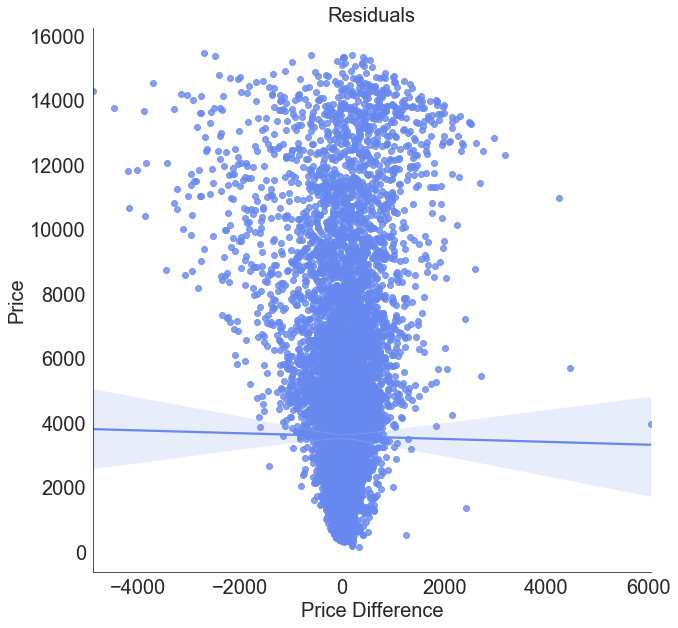

In [23]:
plt.figure(figsize = (10,10))
residuals = y_test - y_pred
sns.regplot(residuals, y_pred)
sns.despine()
plt.title('Residuals')
plt.xlabel('Price Difference')
plt.ylabel('Price')

# Feature Importances

In [24]:
feature_names = list(X.columns)
feature_importance_values = model.feature_importance() 
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

# Normalizing the feature importance values to sum up to 1
feature_importances['Normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Adding a column ofcumulative feature importances data for plotting purposes
feature_importances['Total'] = np.cumsum(feature_importances['Normalized'])

feature_importances.sort_values(by=['Normalized'])
feature_importances

,feature,importance,Normalized,Total
0,carat,26814,0.371462,0.371462
1,depth,11483,0.159077,0.530540
2,table,5924,0.082067,0.612606
3,color_D,1689,0.023398,0.636005
4,color_E,1392,0.019284,0.655288
5,color_F,1440,0.019949,0.675237
6,color_G,1103,0.015280,0.690517
7,color_H,1588,0.021999,0.712516
8,color_I,2026,0.028067,0.740583
9,color_J,1718,0.023800,0.764383


Text(0.5, 1.0, 'Feature Importance')

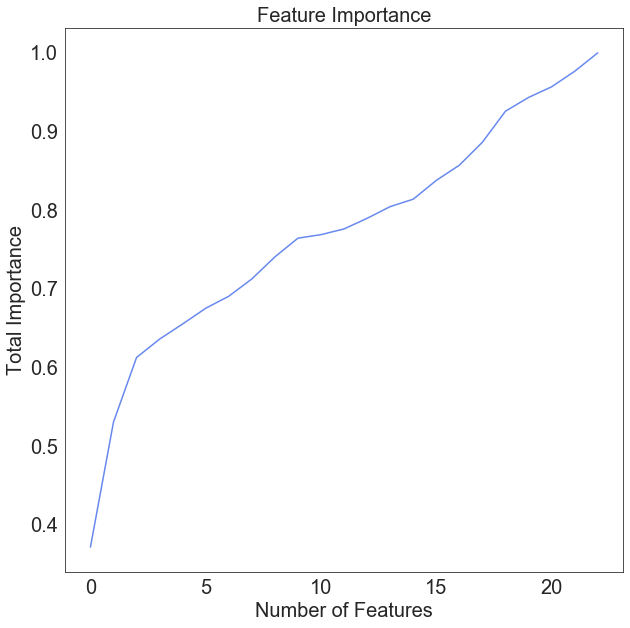

In [25]:
plt.figure(figsize = (10,10))
plt.plot([i for i in range(0, len(feature_importances))], feature_importances['Total'])
plt.xlabel('Number of Features'); plt.ylabel('Total Importance'); 
plt.title('Feature Importance')


# Learning Curve

In [26]:
learning_curve_.head()

,train_rmse,validation_rmse,fold,Iterations
0,3461.889893,3400.565402,1,1
1,3429.879082,3368.748388,1,2
2,3398.211985,3337.261938,1,3
3,3366.885468,3306.109144,1,4
4,3335.896076,3275.296300,1,5


C:\Users\CEM\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


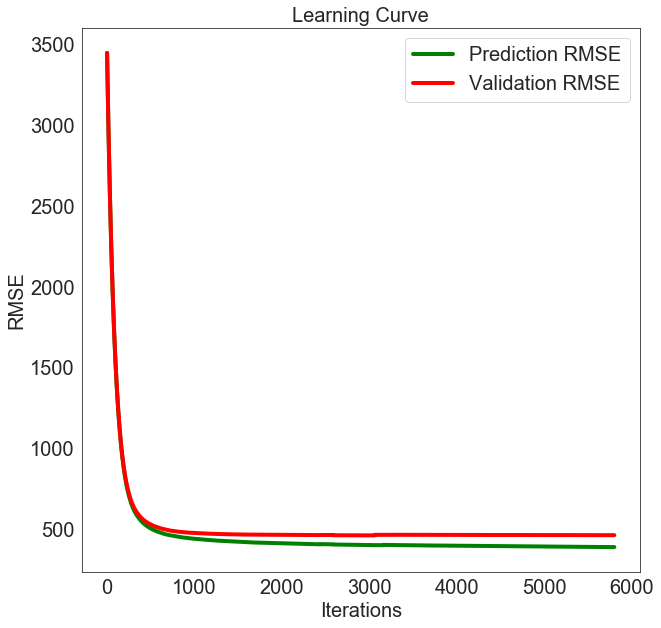

In [27]:
learning_curve = learning_curve_.groupby(['Iterations'])['train_rmse', 'validation_rmse'].mean()

plt.figure(figsize=(10,10))
plt.plot(learning_curve['train_rmse'], label='Prediction RMSE', color='green', linewidth=4)
plt.plot(learning_curve['validation_rmse'], label='Validation RMSE', color='red', linewidth=4)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()